# Analysis of AWS pings

## Process to generate input file

Generate file pingWithoutQuotes.txt by running the following commands:

`mysql -u awsindex_admin -p -h aws-index.ckidp9rjzhn2.eu-west-1.rds.amazonaws.com aws_index -e "select * from ping" | sed 's/\t/","/g;s/^/"/;s/$/"/;s/\n//g' > ping.tx`

`sed 's/"//g' ping.txt > pingWithoutQuotes.txt`




## Configuration

In [35]:
import numpy as np
import pandas as pd
from scipy import constants
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


In [36]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300

In [37]:
def valuesGreaterThanPercentile95(group,q95):
    outliers = group[group['latency'] > q95]
    return outliers.index

def removeLatencyGreaterThanP95AtGroupLevel(df):
    dfGrouped = df.groupby(['origin','destination'])
    q95 = dfGrouped.quantile(.95)
    df95 = df.copy(deep=True)
    for (name,group) in dfGrouped:
        df95.drop(valuesGreaterThanPercentile95(group,q95.loc[name].values[0]), inplace=True)
    return df95
    

In [38]:
def groupLatencyHist(group, color=None):
    n, bins, patches = plt.hist(group['latency'], bins='auto', histtype='bar', color=color)
    idx = list(n).index(max(n))
    return max(n),bins[idx],bins[idx+1]


## Read file

Read file into a dataframe

In [39]:
raw_df = pd.read_table('pingWithoutQuotes.txt', sep='\t', index_col=0, skiprows=0, parse_dates=[4])
raw_df.rename(columns={"des,ina,ion":"destination","la,ency":"latency","crea,ed_a,":"created_at","upda,ed_a,":"updated_at"}, inplace=True)
raw_df = raw_df.drop(columns='updated_at')
raw_df.head()

,origin,destination,latency,created_at
id,,,,
14,ireland,ireland,0.018224,2018-09-28 13:57:59
15,ireland,oregon,0.274516,2018-09-28 13:57:59
16,ireland,saopaulo,0.397710,2018-09-28 13:58:00
17,ireland,sydney,0.564758,2018-09-28 13:58:00
18,sydney,sydney,0.009951,2018-09-28 13:58:03


Quick look at resulting dataframe

In [40]:
print(raw_df.shape)
print(raw_df.columns)
print(raw_df.index)

(575104, 4)
Index(['origin', 'destination', 'latency', 'created_at'], dtype='object')
Int64Index([    14,     15,     16,     17,     18,     19,     20,     21,
                22,     23,
            ...
            575108, 575109, 575110, 575111, 575112, 575113, 575114, 575115,
            575116, 575117],
           dtype='int64', name='id', length=575104)


Removing same origin-destination records

In [41]:
df = raw_df.drop(index = raw_df[raw_df['origin'] == raw_df['destination']].index)
df.head()

,origin,destination,latency,created_at
id,,,,
15,ireland,oregon,0.274516,2018-09-28 13:57:59
16,ireland,saopaulo,0.397710,2018-09-28 13:58:00
17,ireland,sydney,0.564758,2018-09-28 13:58:00
19,sydney,oregon,0.329265,2018-09-28 13:58:03
20,sydney,ireland,0.564223,2018-09-28 13:58:04


In [42]:
#Checkpoint: number of elemenets on df after removing same origin-destination rows is the one expected
raw_df.shape[0]/16*12 == df.shape[0]

True


===============================================================
============================================================

## Data analysis

Study of the latency between different regions

In [43]:
dfGrouped = df.groupby(['origin','destination'])
dfGrouped.mean().sort_values('latency')

,,latency
origin,destination,
oregon,ireland,0.277883
ireland,oregon,0.292310
oregon,sydney,0.312491
sydney,oregon,0.330265
ireland,saopaulo,0.400503
saopaulo,ireland,0.400773
oregon,saopaulo,0.410371
saopaulo,oregon,0.424991
sydney,ireland,0.551629


In [44]:
statistics_df = dfGrouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  oregon       35944.0  0.292310  0.280538  0.252901  0.264472   
         saopaulo     35944.0  0.400503  0.026176  0.363092  0.368585   
         sydney       35944.0  0.552955  0.212694  0.526941  0.546206   
oregon   ireland      35944.0  0.277883  0.235026  0.253431  0.264601   
         saopaulo     35944.0  0.410371  0.120691  0.354225  0.370508   
         sydney       35944.0  0.312491  0.110199  0.277635  0.278574   
saopaulo ireland      35944.0  0.400773  0.028217  0.351929  0.368553   
         oregon       35944.0  0.424991  0.243119  0.353950  0.370610   
         sydney       35944.0  0.676562  0.052151  0.616921  0.643967   
sydney   ireland      35944.0  0.551629  0.036213  0.527321  0.546321   
         oregon       35944.0  0.330265  0.318805  0.277737  0.278684   
         saopaulo     35944.0  0.676430  0.032008  0.617259  0.644053   

                                                                         
                           25%       50%       75%       95%        max  
origin   destination                                                     
ireland  oregon       0.267193  0.269703  0.270544  0.329631  17.807876  
         saopaulo     0.387913  0.392260  0.414571  0.443456   1.580449  
         sydney       0.549477  0.550405  0.554282  0.554955  33.217968  
oregon   ireland      0.267351  0.269812  0.270660  0.316032  31.316430  
         saopaulo     0.390924  0.396104  0.418570  0.477541  15.443505  
         sydney       0.279361  0.323429  0.323728  0.324520  15.351883  
saopaulo ireland      0.388023  0.392306  0.414528  0.463574   1.589403  
         oregon       0.391132  0.396942  0.420125  0.478684  12.934621  
         sydney       0.663648  0.669342  0.690344  0.722081   7.730569  
sydney   ireland      0.549543  0.550518  0.554366  0.555040   5.938220  
         oregon       0.279379  0.323445  0.323759  0.328107  31.301684  
         saopaulo     0.663782  0.669374  0.690338  0.721138   3.371987

The maximum values are way too high compared to their respective median (percentile 50). To avoid having these outliers affect the overall statistics, we will remove all the values above percentile 95

### Latency after removing outliers

In [45]:
df95 = removeLatencyGreaterThanP95AtGroupLevel(df)
df95Grouped = df95.groupby(['origin','destination'])
df95Grouped.mean().sort_values('latency')

,,latency
origin,destination,
oregon,ireland,0.269971
ireland,oregon,0.271157
oregon,sydney,0.309329
sydney,oregon,0.309452
ireland,saopaulo,0.397031
saopaulo,ireland,0.397153
oregon,saopaulo,0.403891
saopaulo,oregon,0.405521
ireland,sydney,0.550614


In [46]:
statistics_df95 = df95Grouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df95[('latency','width')] = statistics_df95[('latency','max')] - statistics_df95[('latency','min')]
statistics_df95

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  oregon       34146.0  0.271157  0.009819  0.252901  0.264456   
         saopaulo     34146.0  0.397031  0.019932  0.363092  0.368565   
         sydney       34146.0  0.550614  0.004187  0.526941  0.546186   
oregon   ireland      34146.0  0.269971  0.005300  0.253431  0.264579   
         saopaulo     34146.0  0.403891  0.025093  0.354225  0.370448   
         sydney       34146.0  0.309329  0.020722  0.277635  0.278561   
saopaulo ireland      34146.0  0.397153  0.019963  0.351929  0.368528   
         oregon       34146.0  0.405521  0.026577  0.353950  0.370551   
         sydney       34146.0  0.672782  0.019847  0.616921  0.643808   
sydney   ireland      34146.0  0.550703  0.004180  0.527321  0.546299   
         oregon       34146.0  0.309452  0.020697  0.277737  0.278673   
         saopaulo     34146.0  0.672879  0.019897  0.617259  0.643909   

                                                                        \
                           25%       50%       75%       95%       max   
origin   destination                                                     
ireland  oregon       0.267158  0.269613  0.270296  0.283176  0.329630   
         saopaulo     0.387738  0.392107  0.413839  0.439257  0.443442   
         sydney       0.549362  0.550334  0.554200  0.554691  0.554955   
oregon   ireland      0.267316  0.269660  0.270478  0.280299  0.315997   
         saopaulo     0.390029  0.395623  0.417054  0.453452  0.477539   
         sydney       0.279266  0.323397  0.323673  0.324136  0.324519   
saopaulo ireland      0.387809  0.392138  0.413956  0.439183  0.459188   
         oregon       0.390582  0.395916  0.418069  0.455020  0.478683   
         sydney       0.663411  0.668875  0.688090  0.710964  0.722010   
sydney   ireland      0.549431  0.550444  0.554280  0.554778  0.555039   
         oregon       0.279296  0.323414  0.323697  0.324323  0.328099   
         saopaulo     0.663557  0.668904  0.688138  0.711205  0.721072   

                                
                         width  
origin   destination            
ireland  oregon       0.076729  
         saopaulo     0.080350  
         sydney       0.028014  
oregon   ireland      0.062566  
         saopaulo     0.123313  
         sydney       0.046884  
saopaulo ireland      0.107259  
         oregon       0.124734  
         sydney       0.105090  
sydney   ireland      0.027718  
         oregon       0.050362  
         saopaulo     0.103812

**Check to make sure that df95 was calculated correctly:**
given that df95 is the result of keeping 95% of the values of df, the following must be true:

In [47]:
dfCount = df.shape[0]
df95Count = df95.shape[0] 
np.round(df95Count/dfCount,2) == 0.95

True

## Histograms

### Ireland

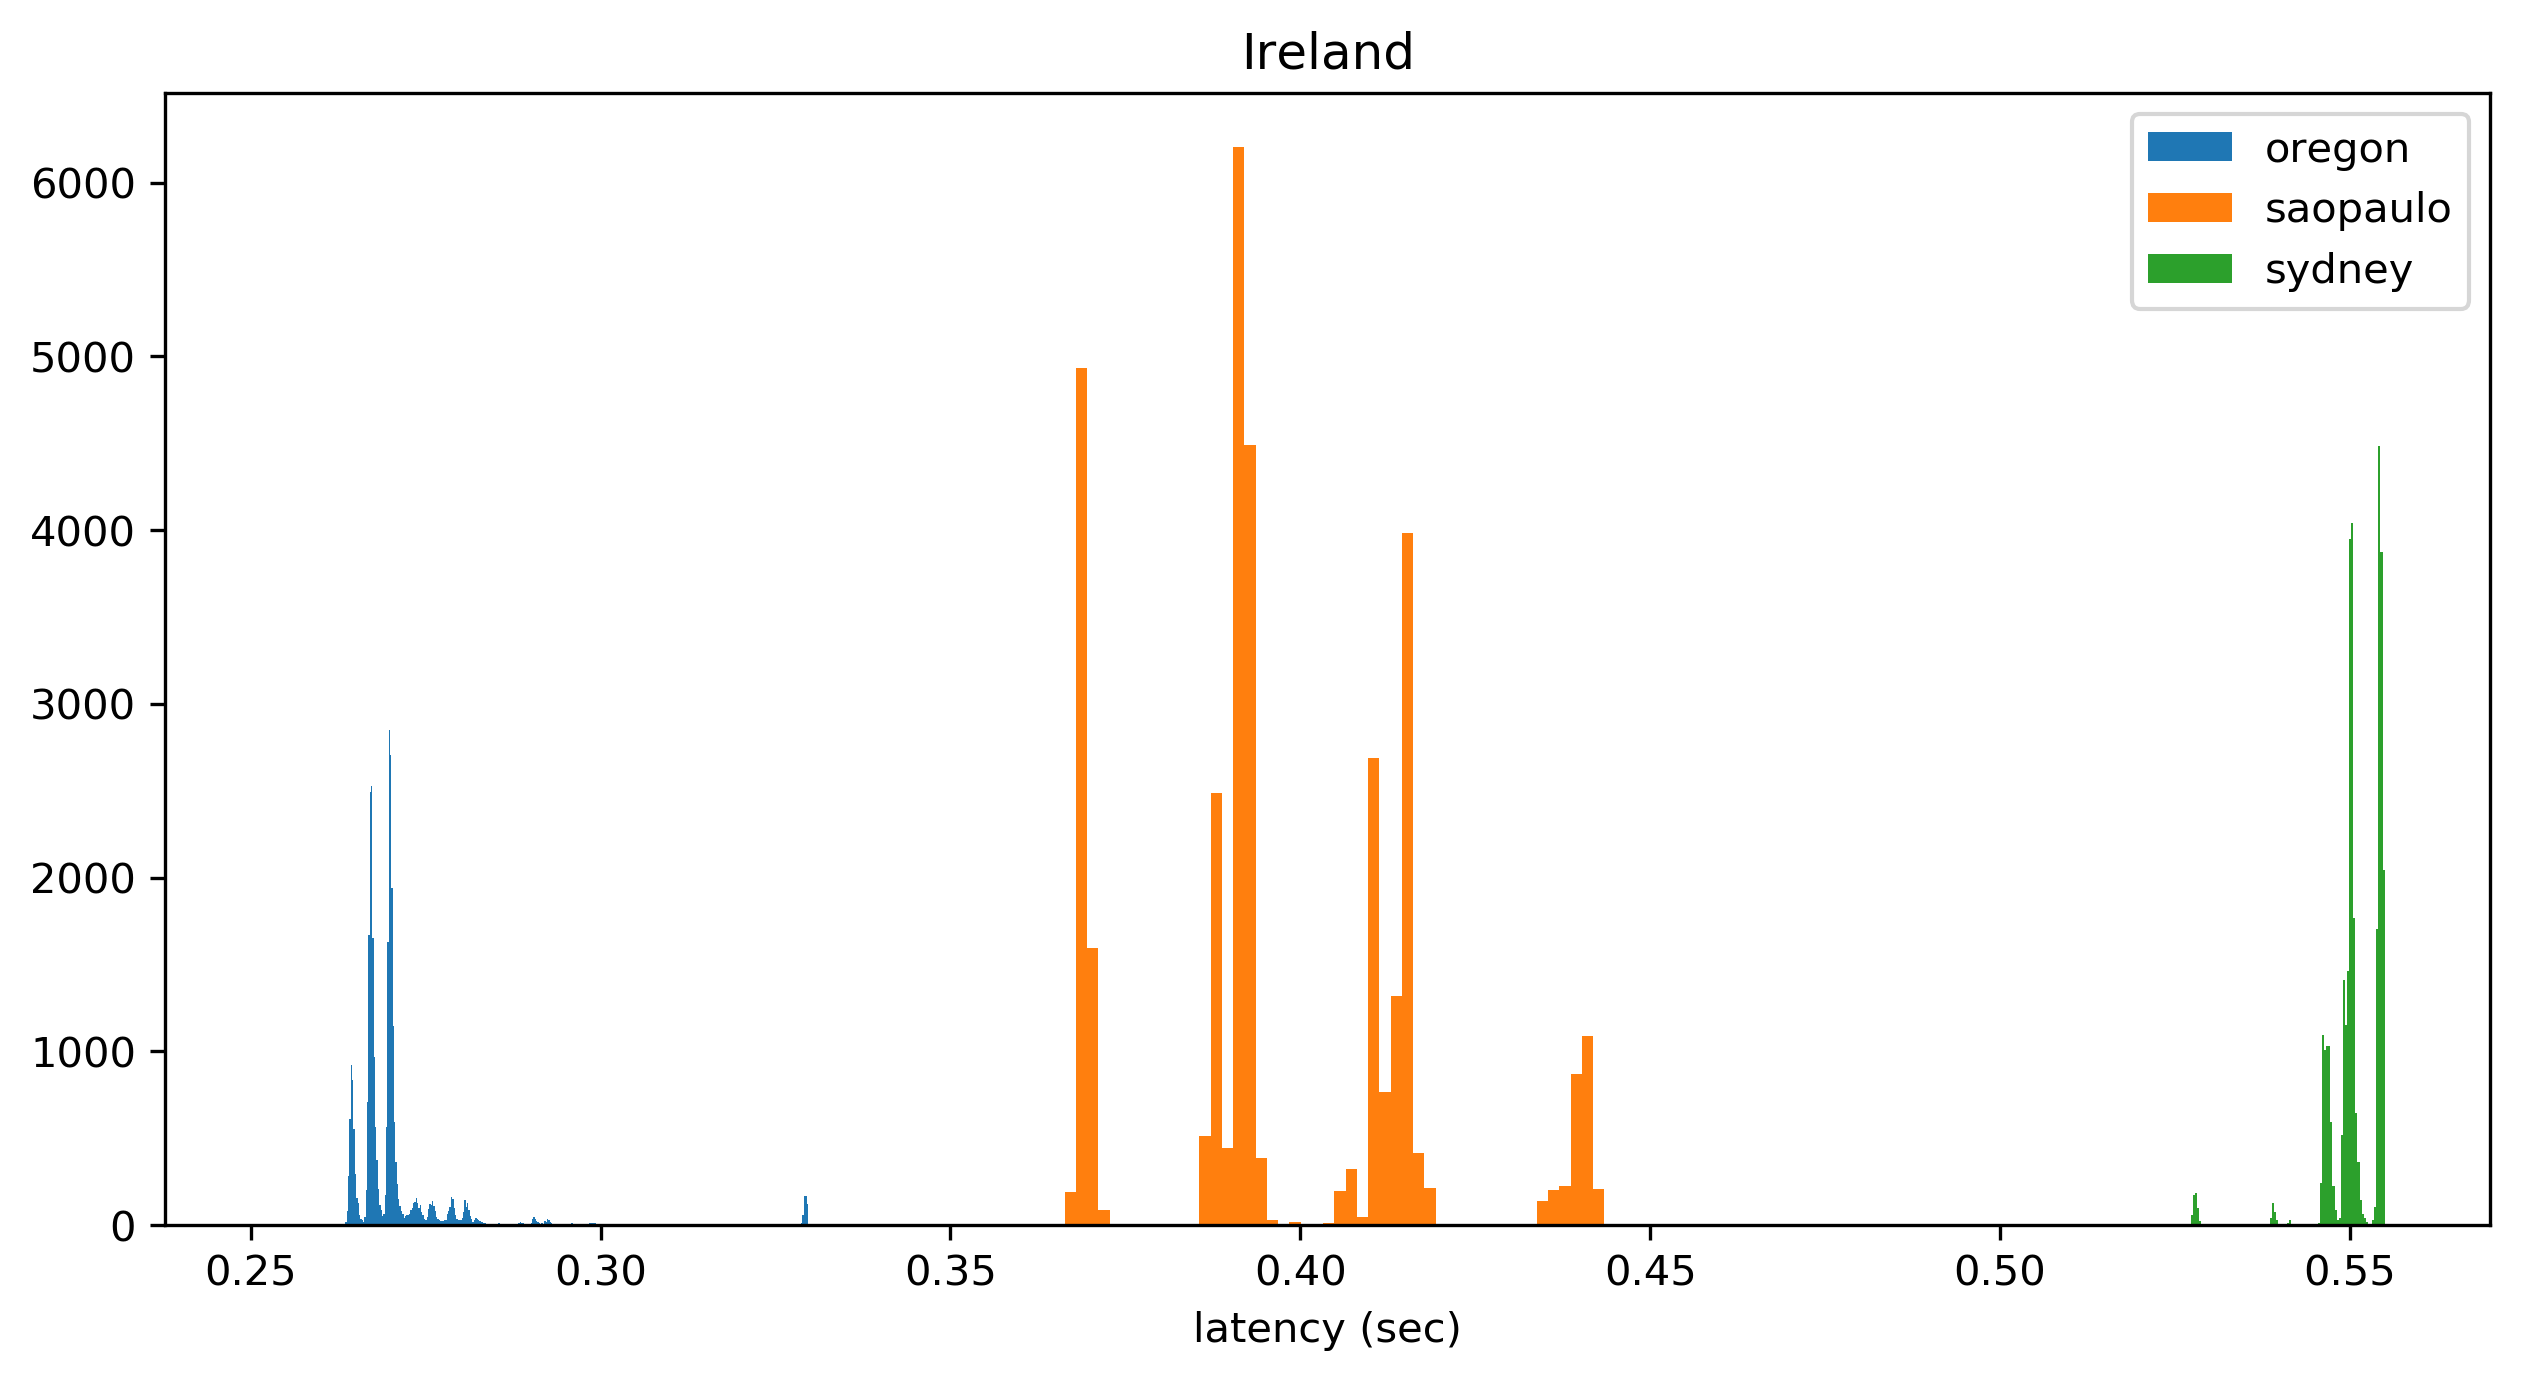

In [48]:
plt.hist(df95Grouped.get_group(('ireland','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('ireland','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.hist(df95Grouped.get_group(('ireland','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Ireland")
plt.xlabel('latency (sec)')
plt.legend()

### Oregon

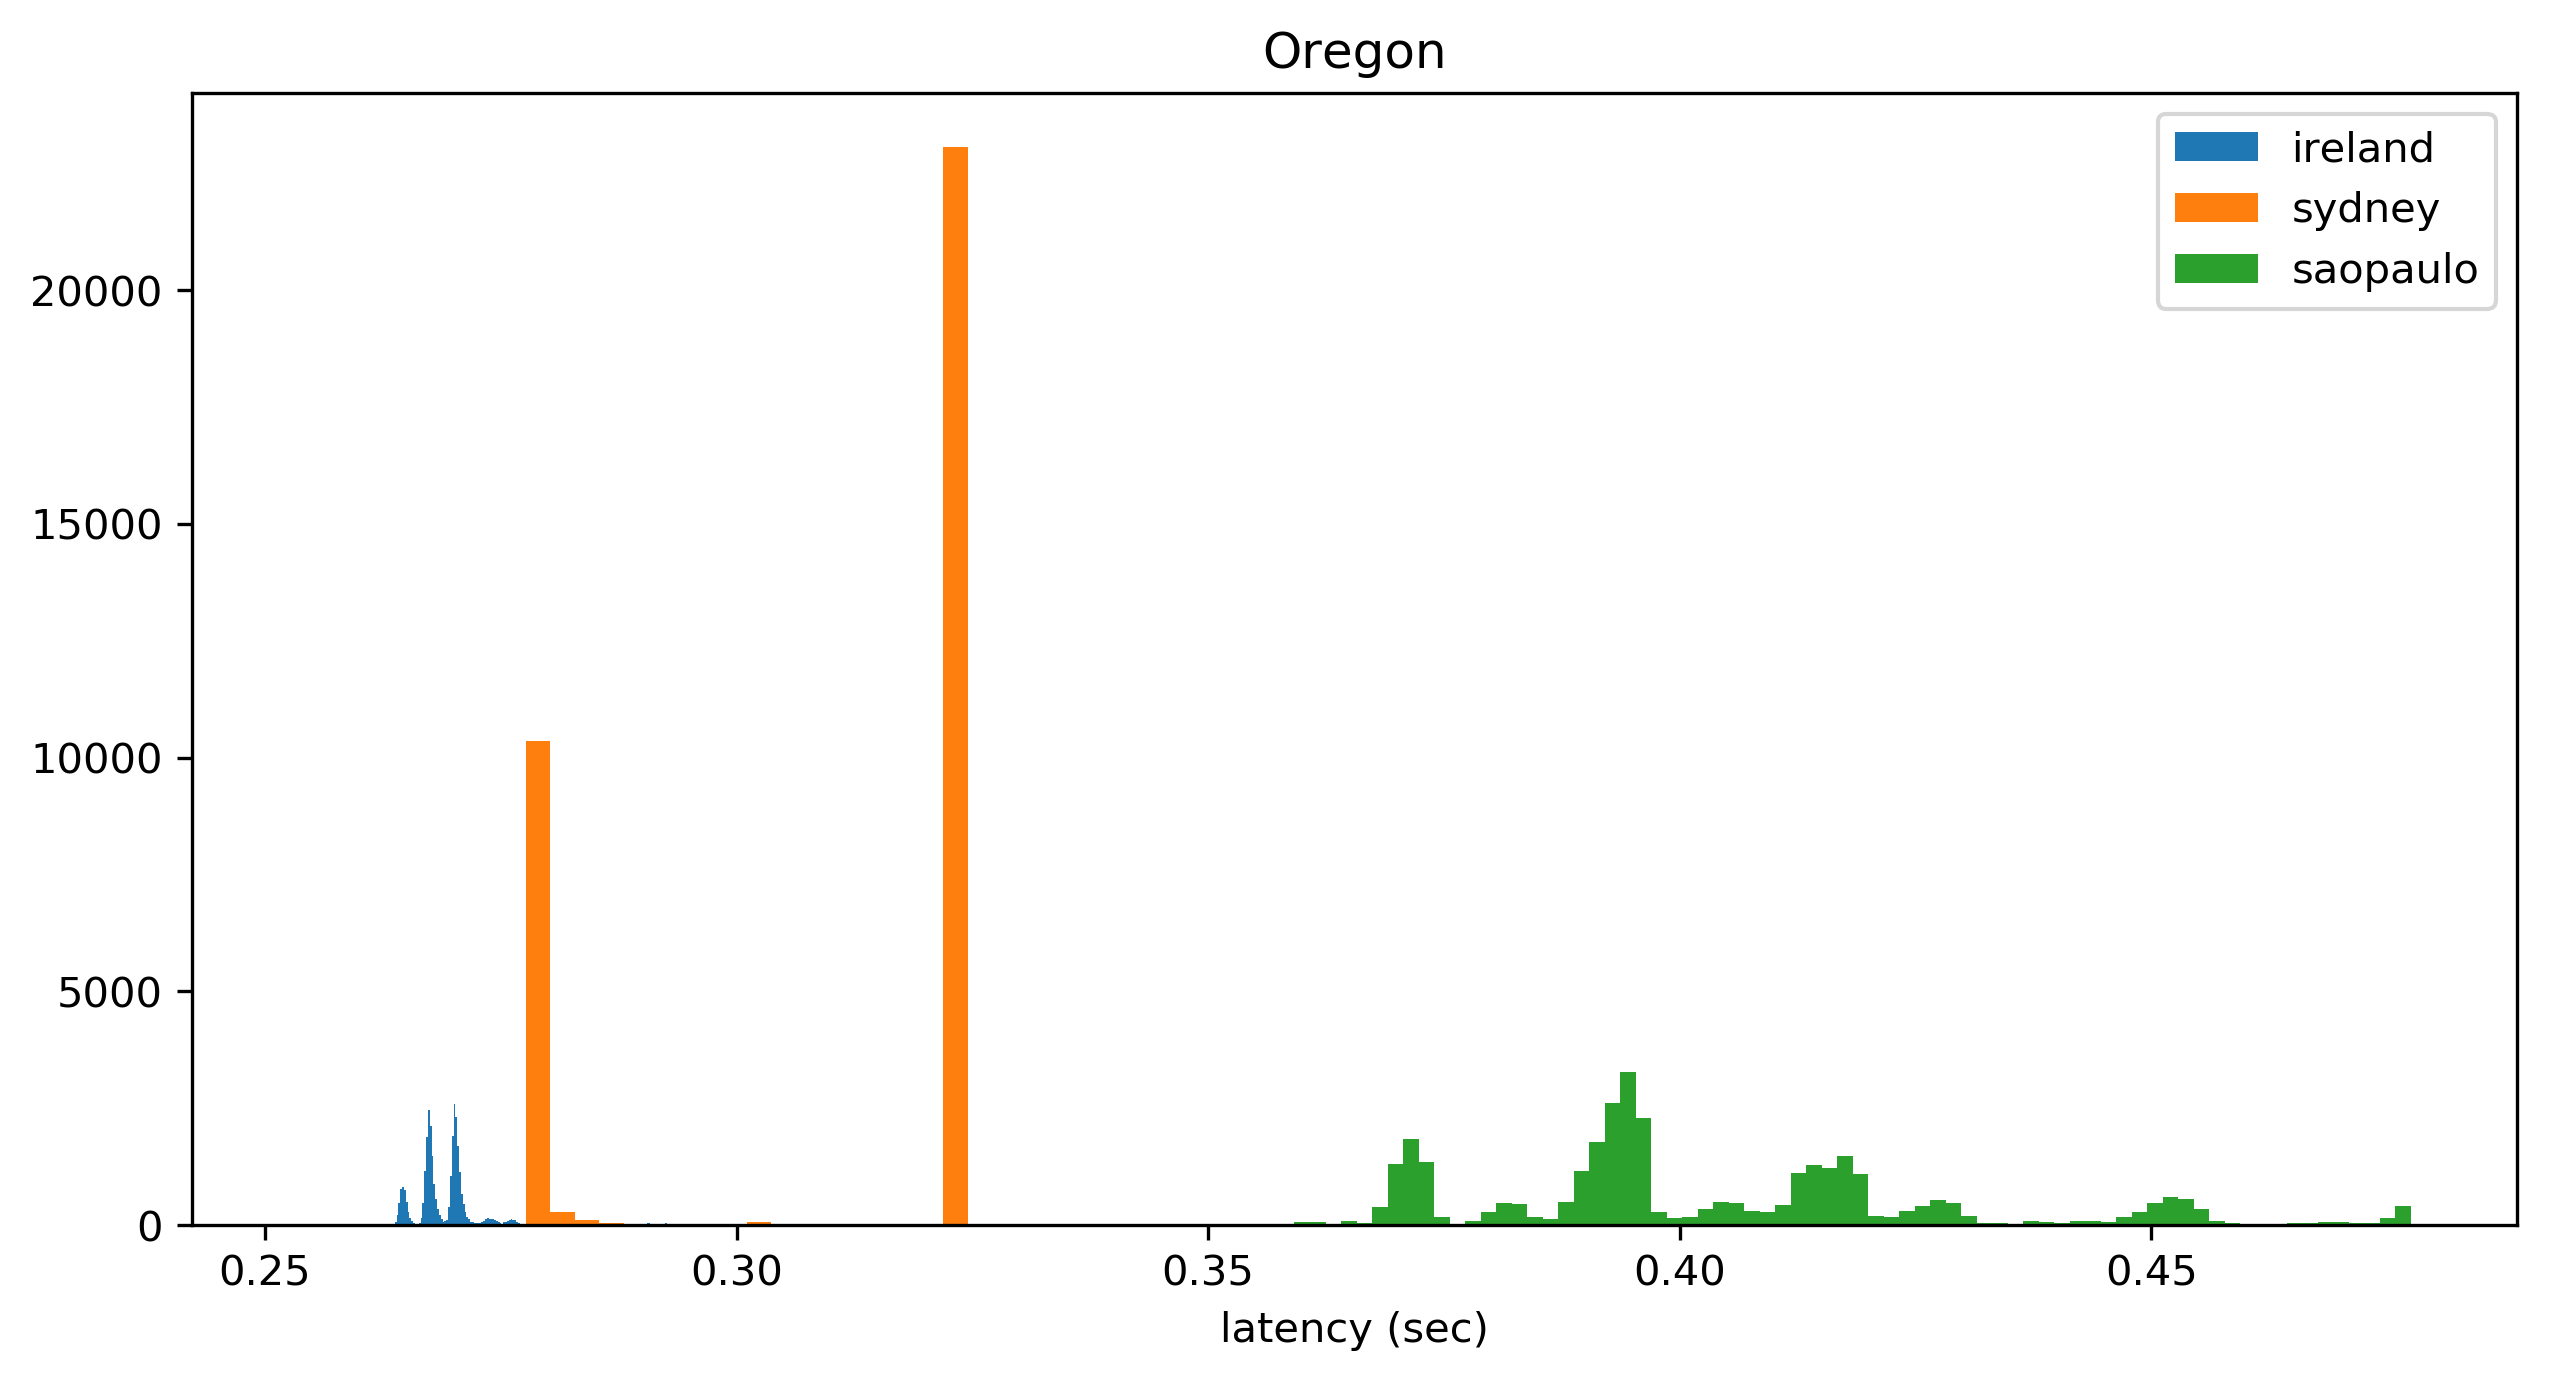

In [49]:
plt.hist(df95Grouped.get_group(('oregon','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('oregon','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.hist(df95Grouped.get_group(('oregon','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Oregon")
plt.xlabel('latency (sec)')
plt.legend()

### Sao Paulo

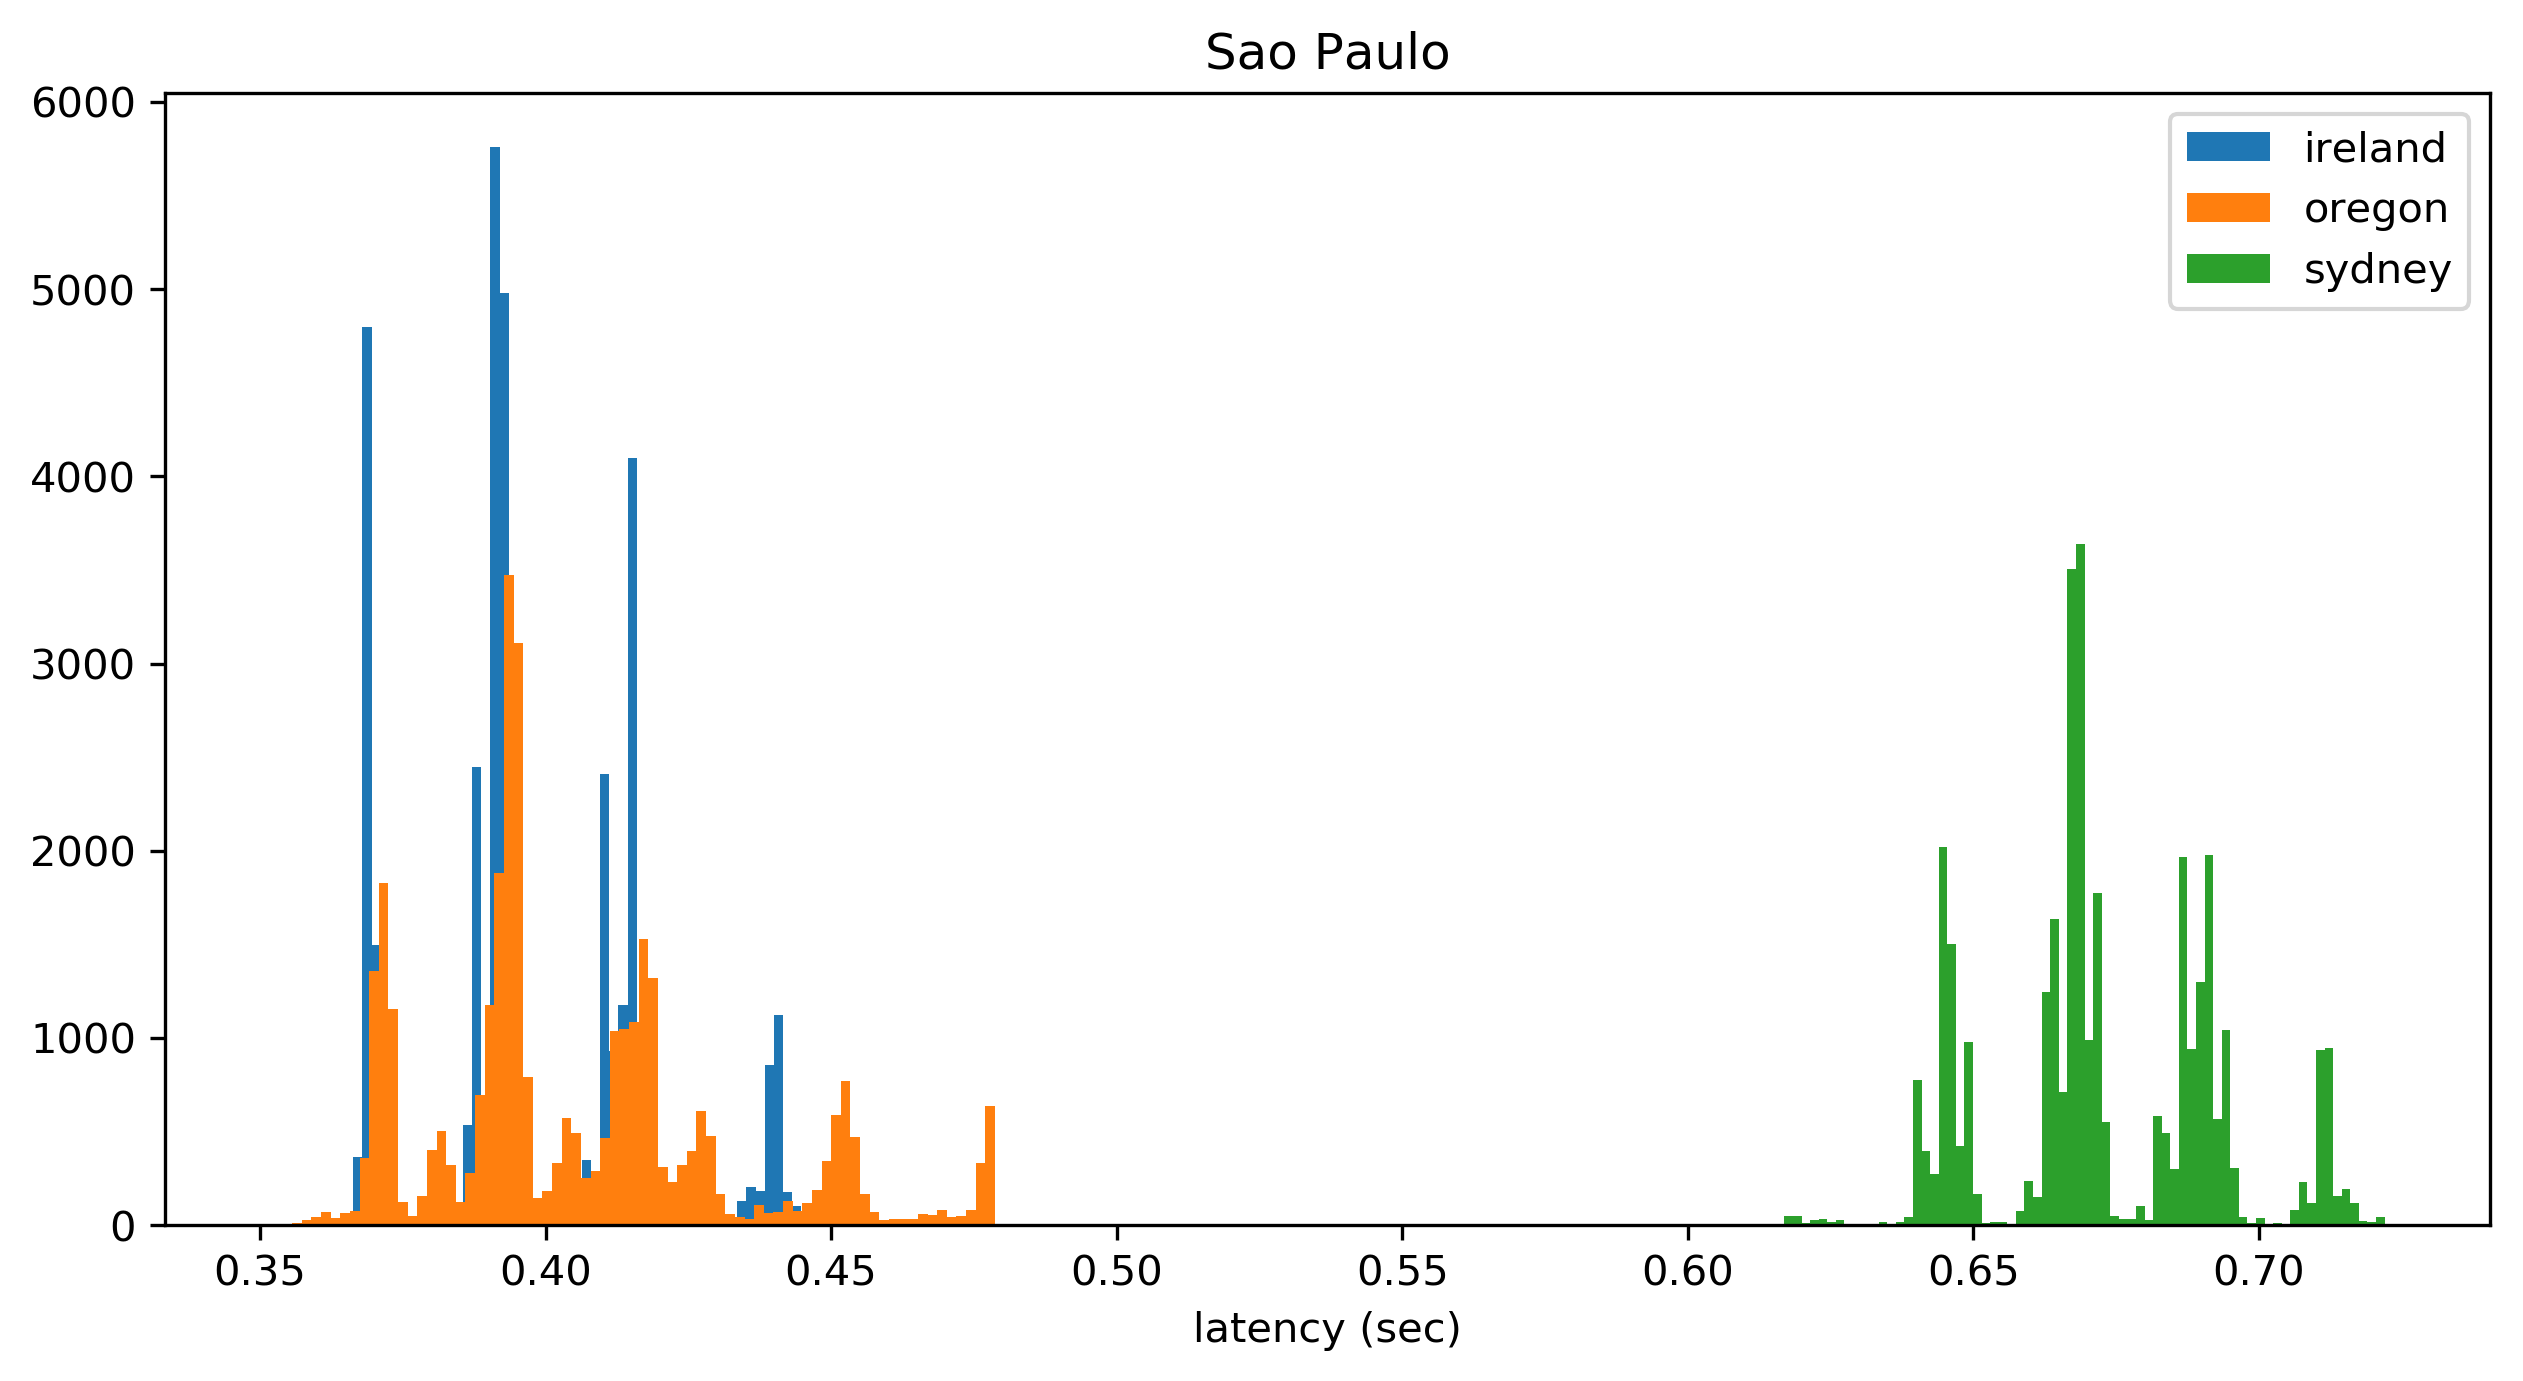

In [50]:
plt.hist(df95Grouped.get_group(('saopaulo','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('saopaulo','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('saopaulo','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Sao Paulo")
plt.xlabel('latency (sec)')
plt.legend()

### Sydney

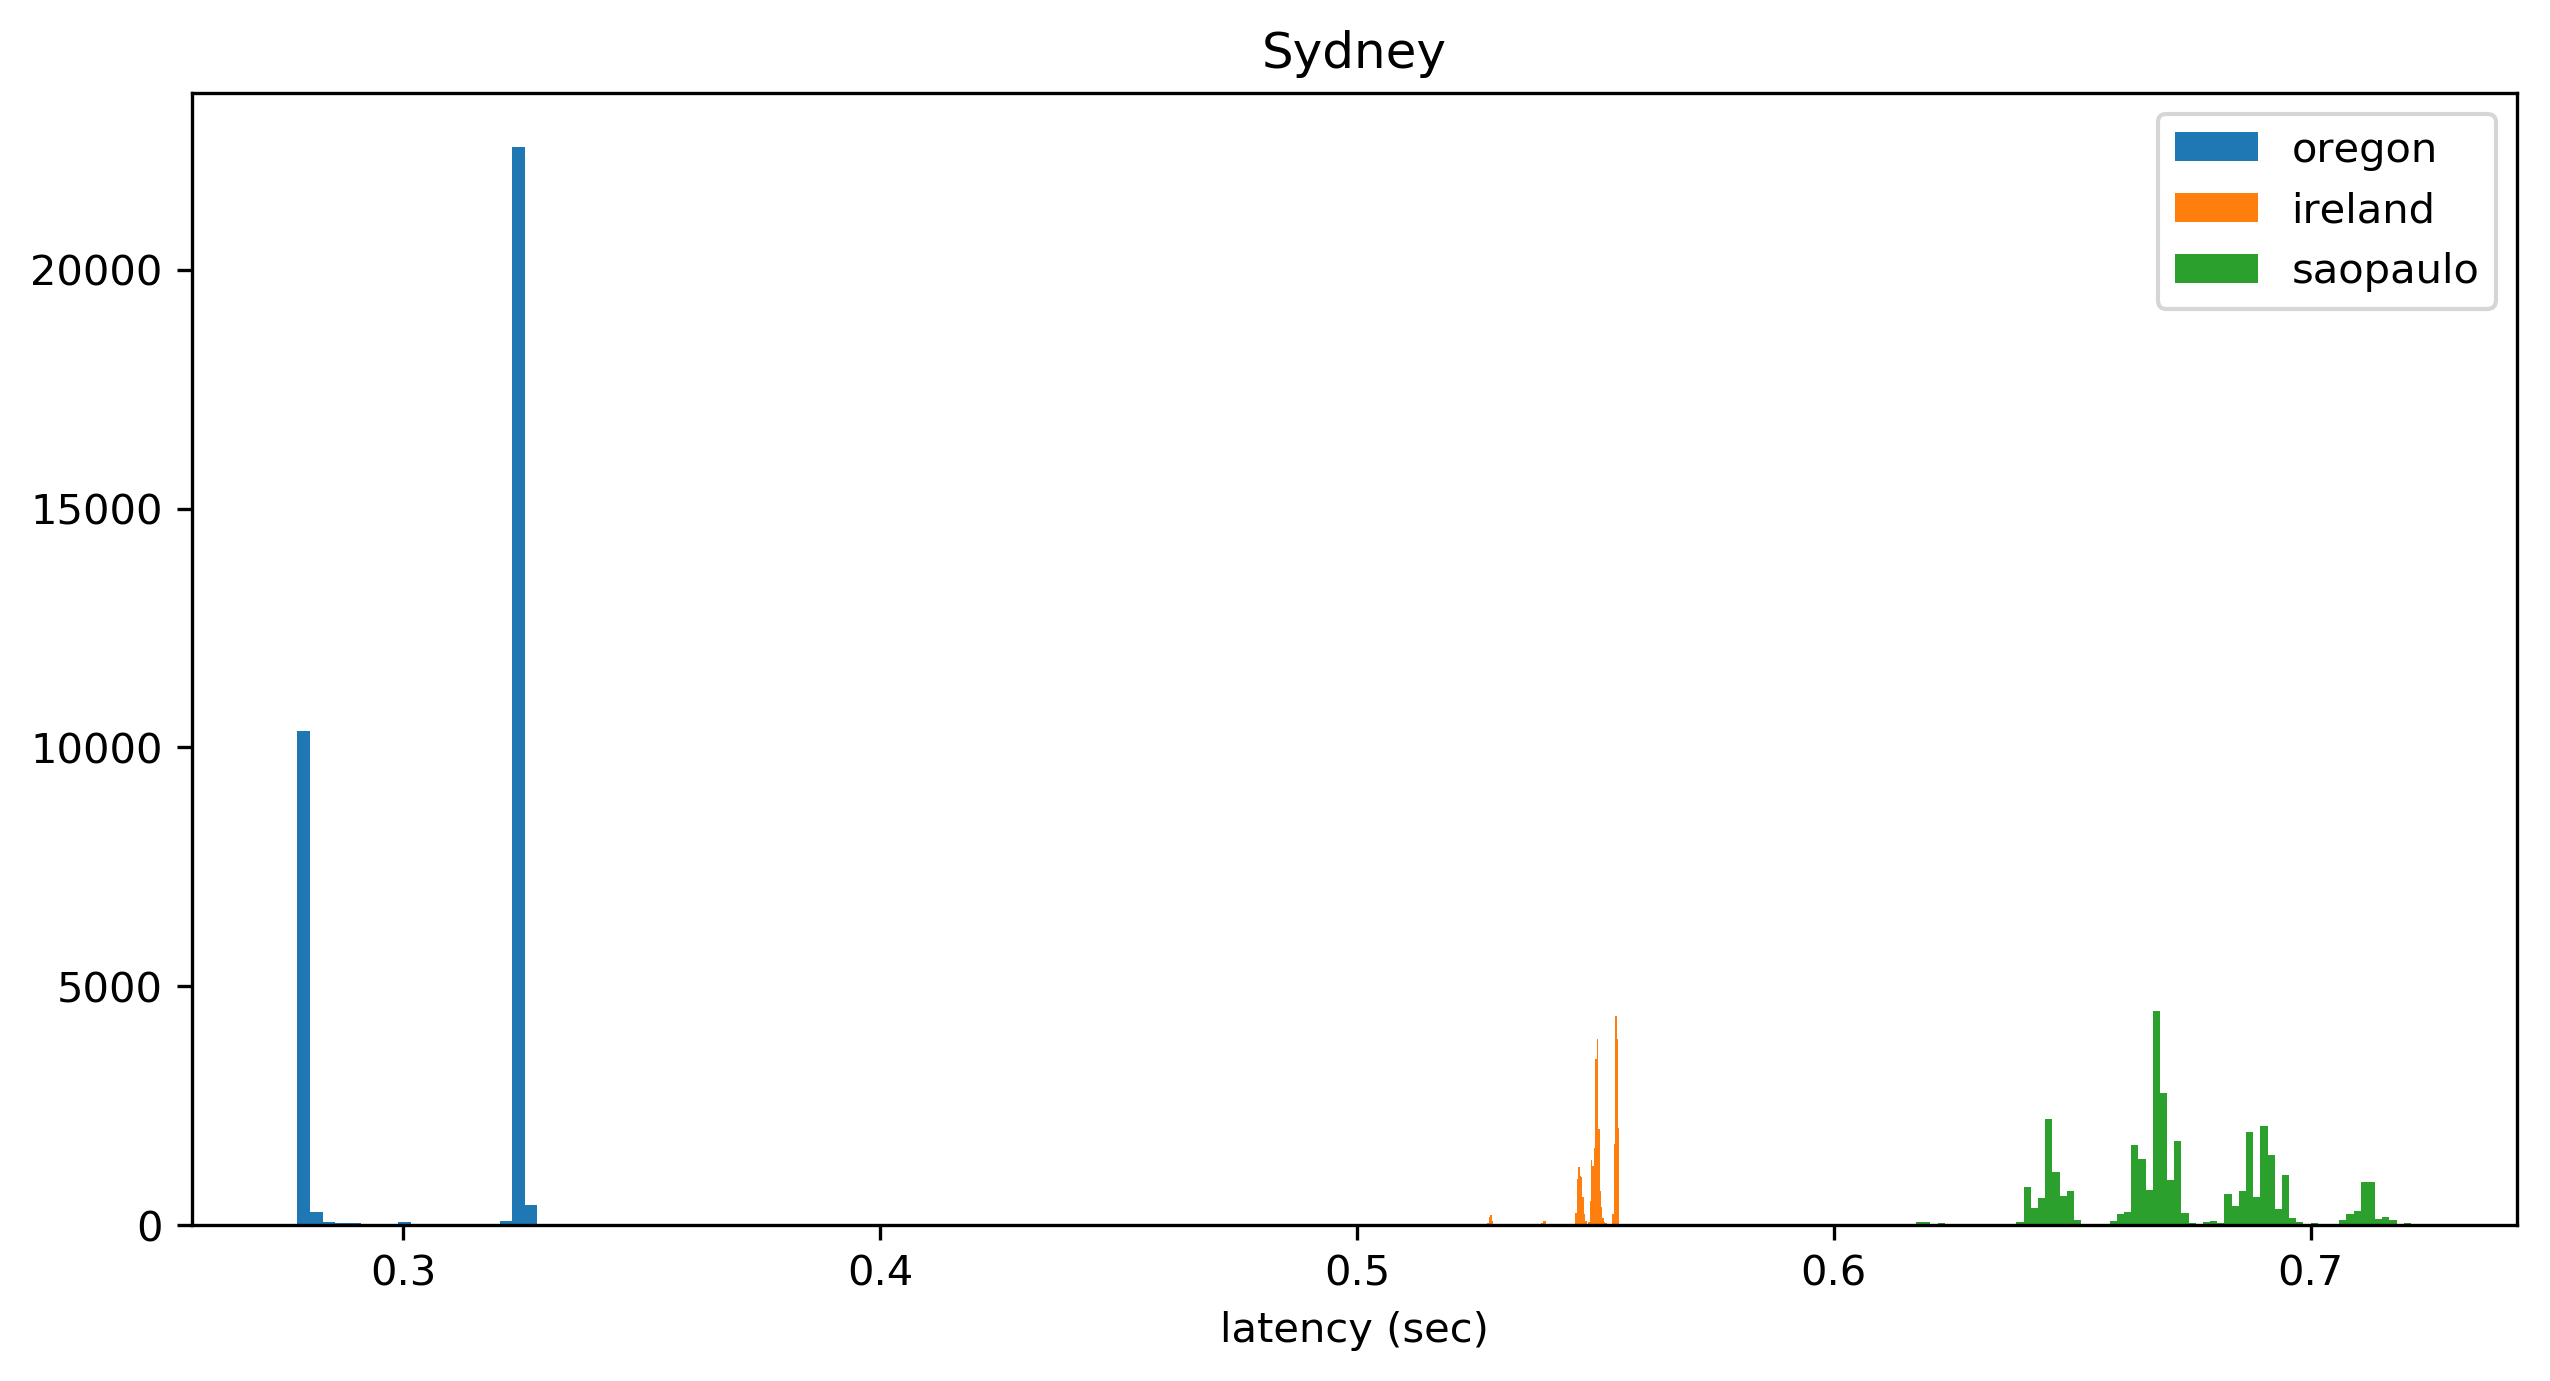

In [51]:
plt.hist(df95Grouped.get_group(('sydney','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('sydney','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('sydney','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Sydney")
plt.xlabel('latency (sec)')
plt.legend()

===============================================================
===============================================================

## Time series analysis

In [52]:
df_ts = df.set_index('created_at')
df95_ts = df95.set_index('created_at')
df_ts_grouped = df_ts.groupby(['origin','destination'])
df95_ts_grouped = df95_ts.groupby(['origin','destination'])

In [53]:
iolatency = df_ts_grouped.get_group(('ireland','oregon'))['latency']
isaolatency = df_ts_grouped.get_group(('ireland','saopaulo'))['latency']
isydlatency = df_ts_grouped.get_group(('ireland','sydney'))['latency']

oilatency = df_ts_grouped.get_group(('oregon','ireland'))['latency']
osaolatency = df_ts_grouped.get_group(('oregon','saopaulo'))['latency']
osydlatency = df_ts_grouped.get_group(('oregon','sydney'))['latency']

saoreglatency = df_ts_grouped.get_group(('saopaulo','oregon'))['latency']
saoilatency = df_ts_grouped.get_group(('saopaulo','ireland'))['latency']
saosydlatency = df_ts_grouped.get_group(('saopaulo','sydney'))['latency']

sydolatency = df_ts_grouped.get_group(('sydney','oregon'))['latency']
sydsaolatency = df_ts_grouped.get_group(('sydney','saopaulo'))['latency']
sydilatency = df_ts_grouped.get_group(('sydney','ireland'))['latency']

iolatency95 = df95_ts_grouped.get_group(('ireland','oregon'))['latency']

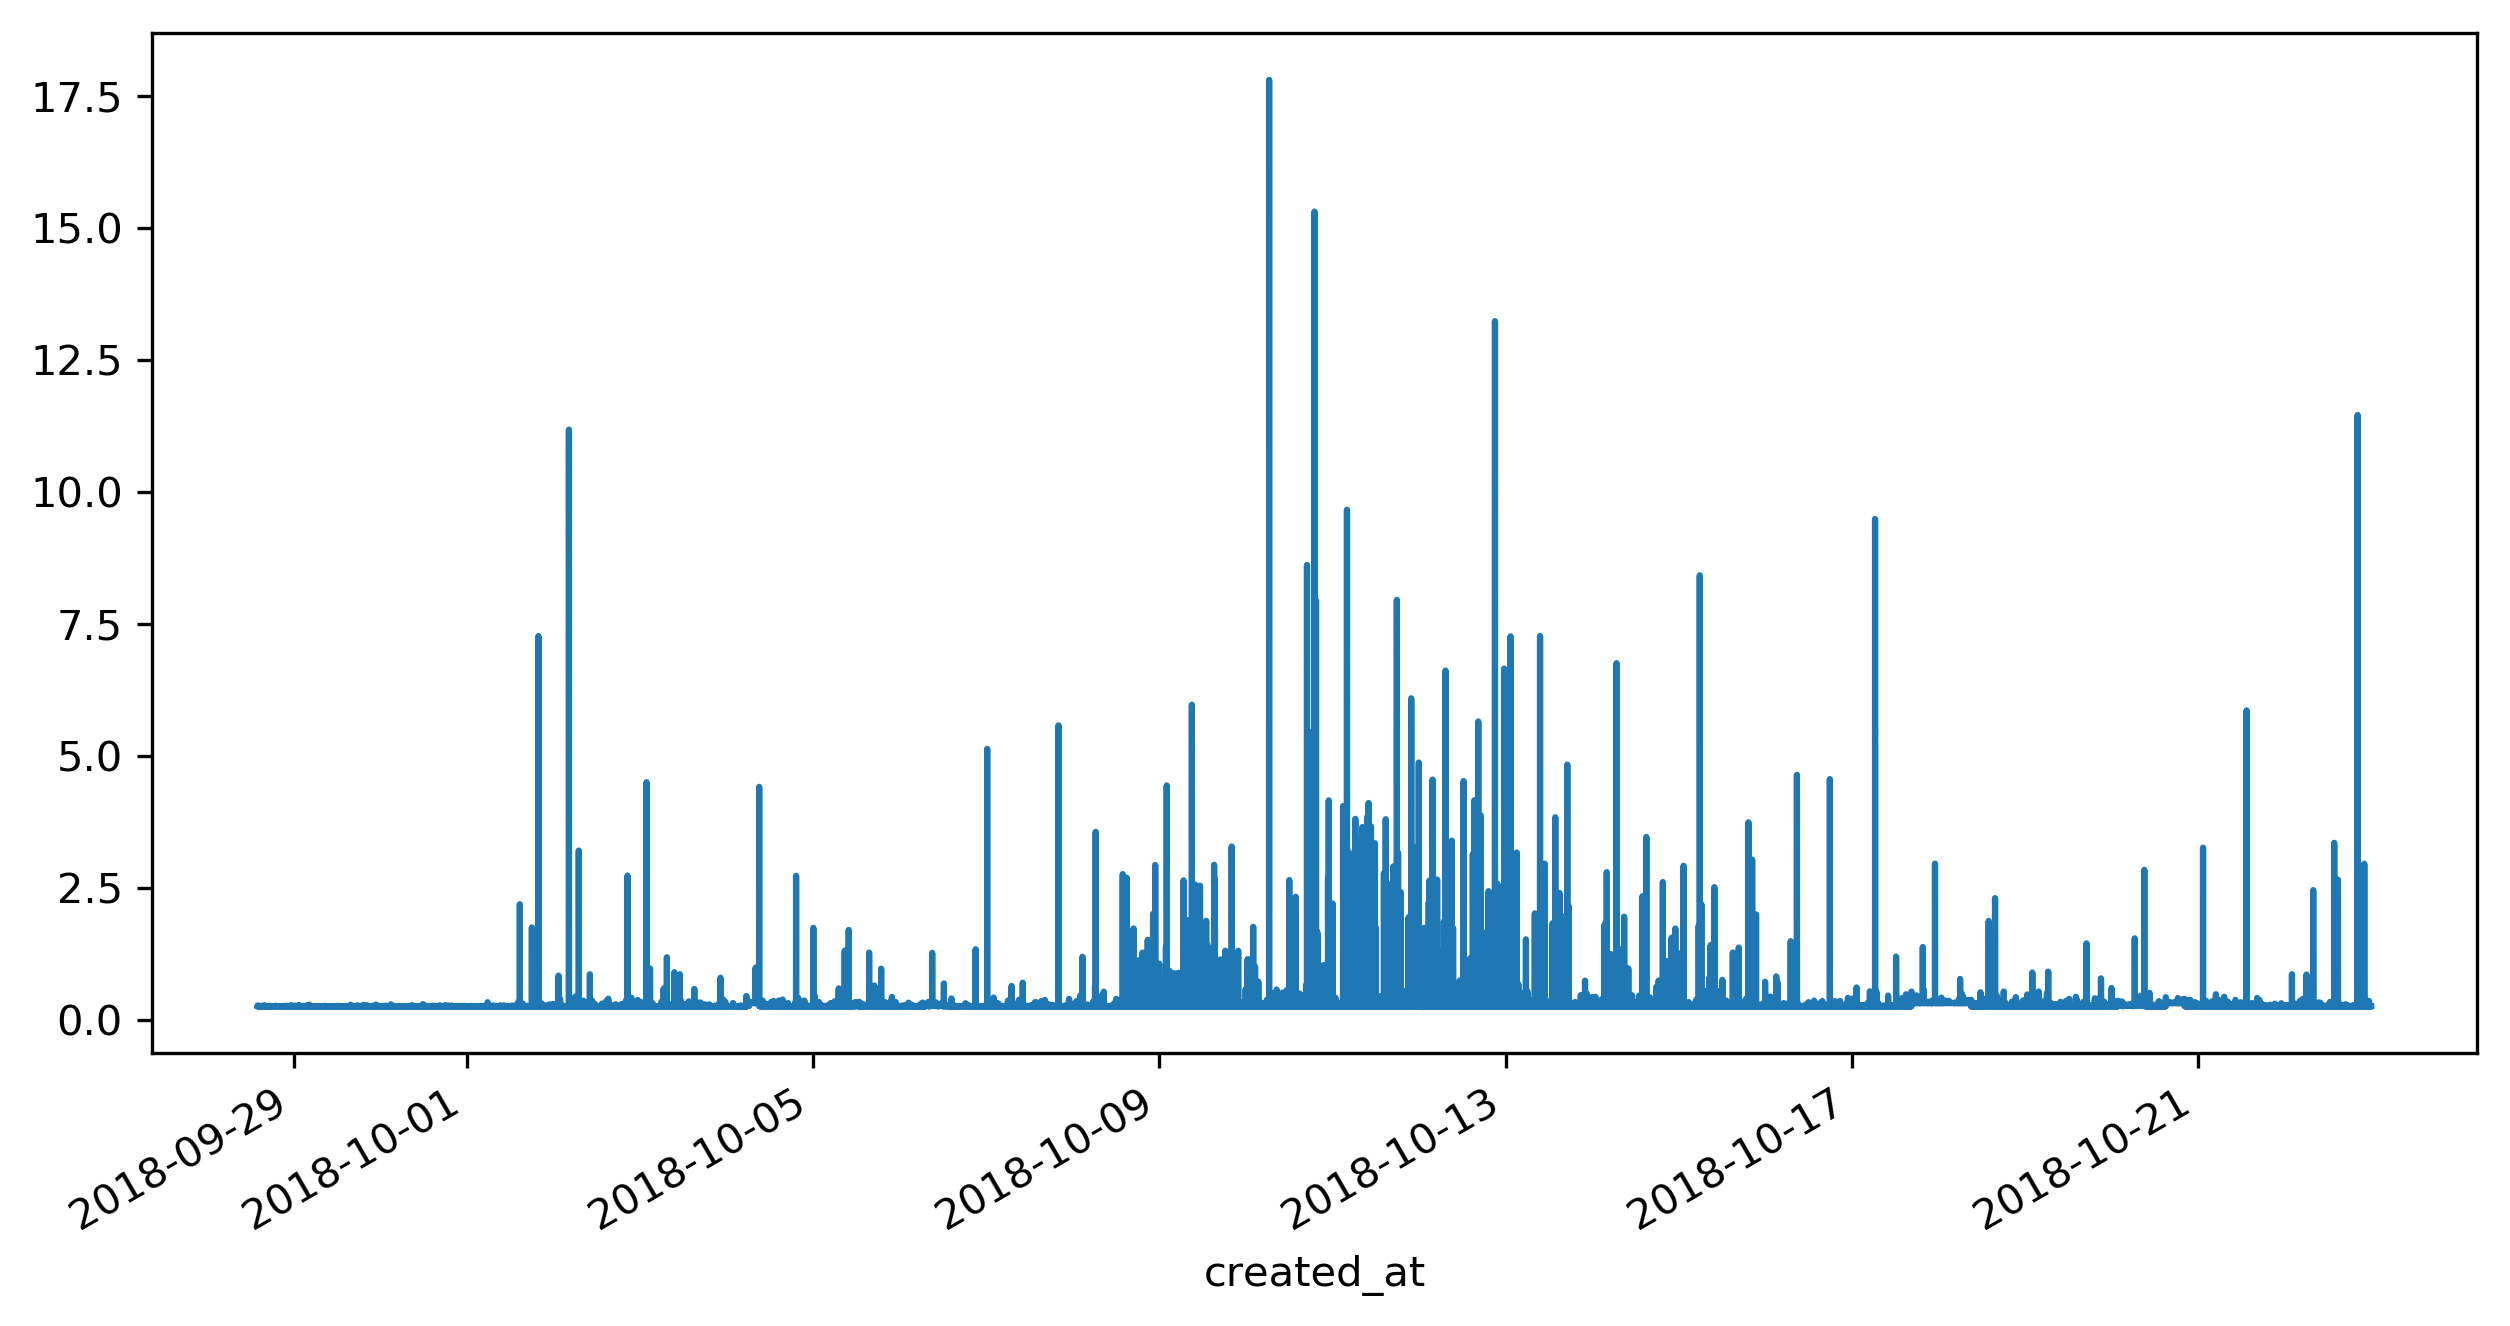

In [54]:
iolatency['2018-09-28':'2018-10-22'].plot()

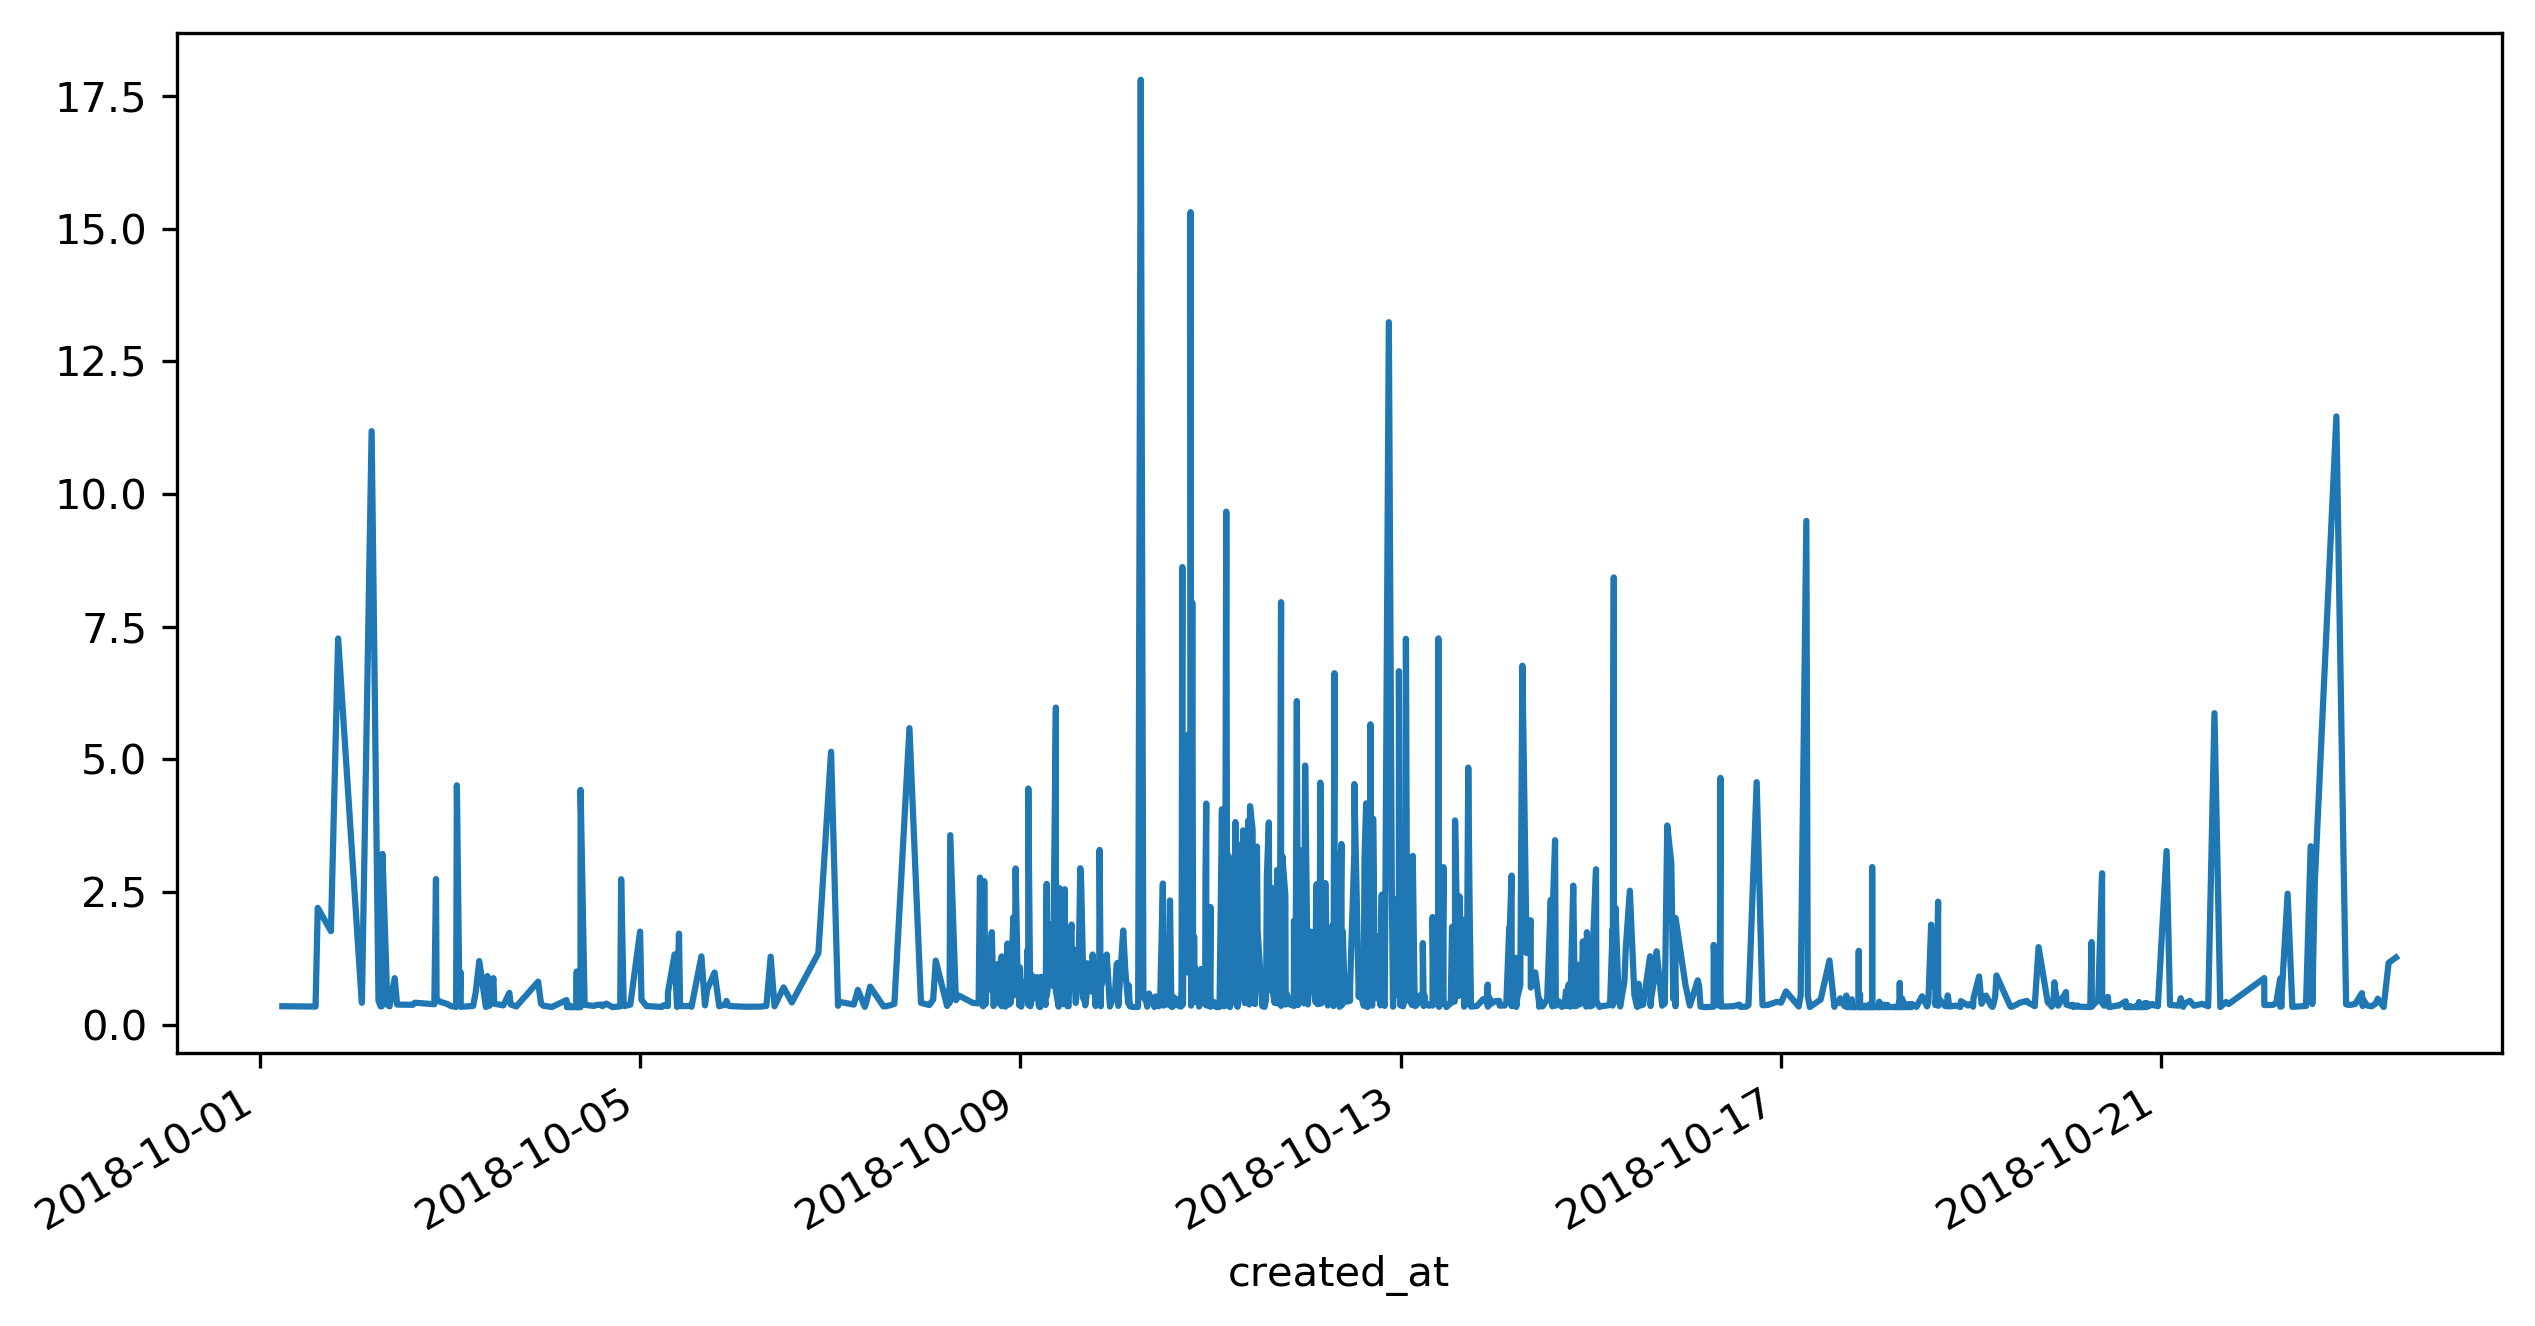

In [55]:
#outliers
iolatency[iolatency > statistics_df.loc[('ireland','oregon'),('latency','95%')]].plot()

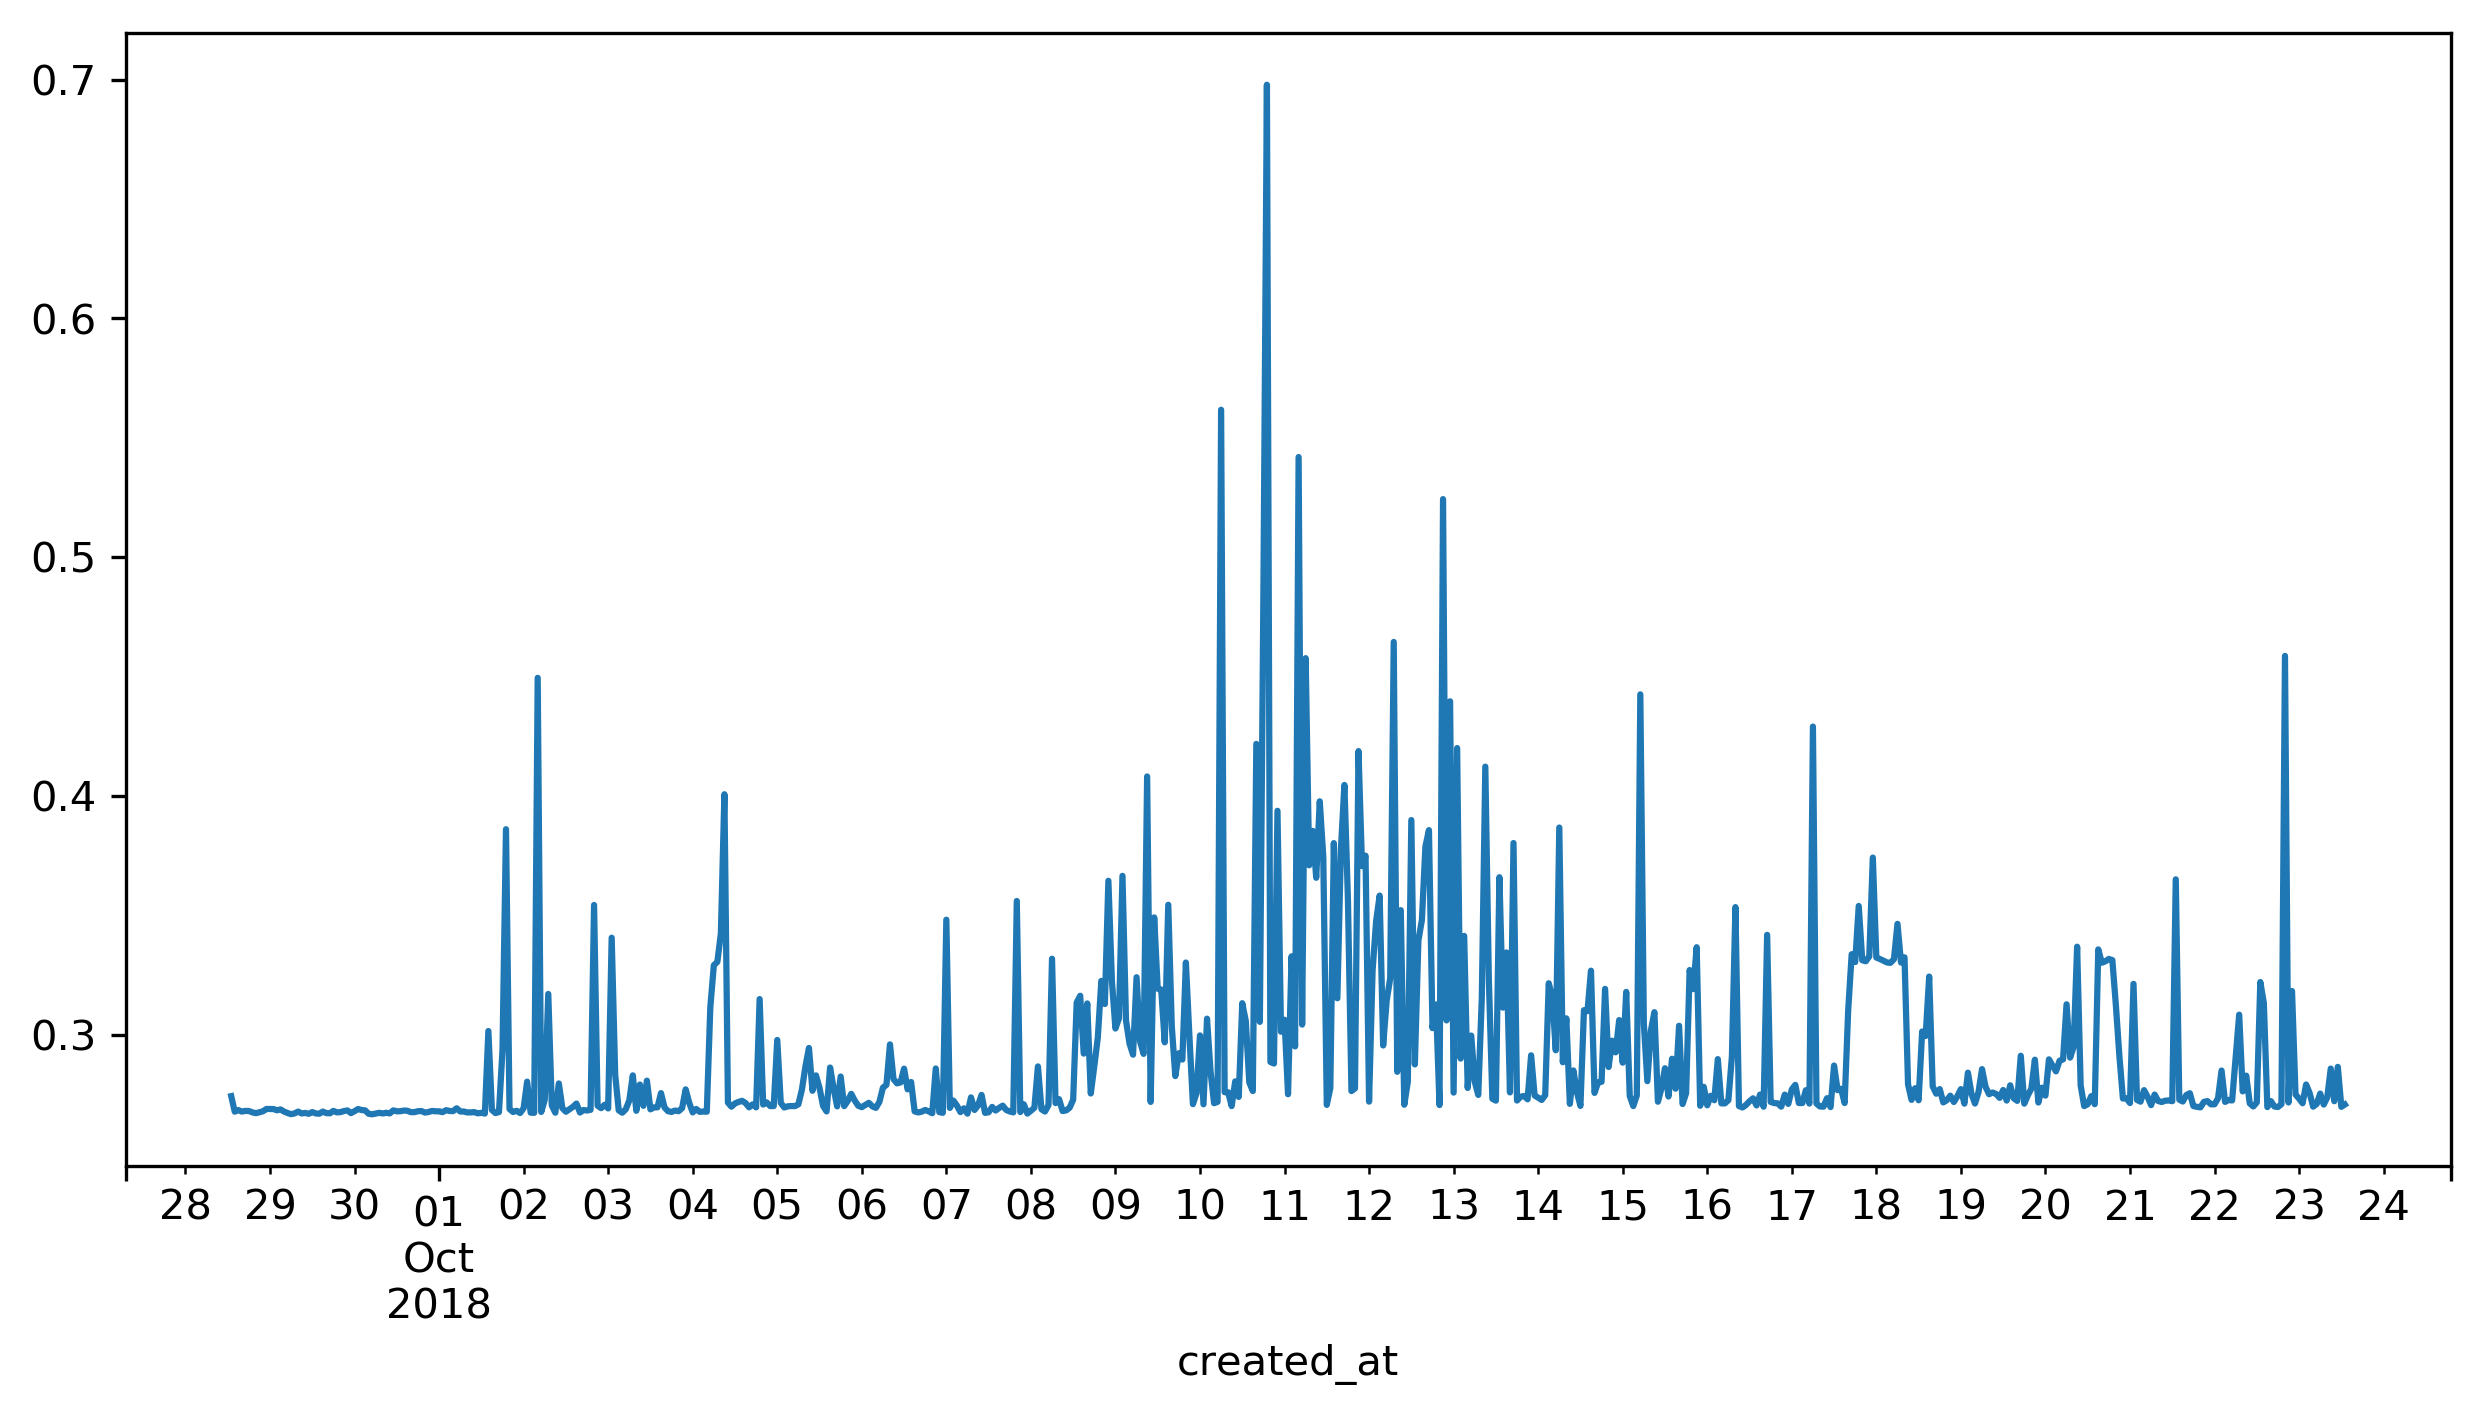

In [56]:
#resampling by hour
iolatency.resample('H').mean().plot()

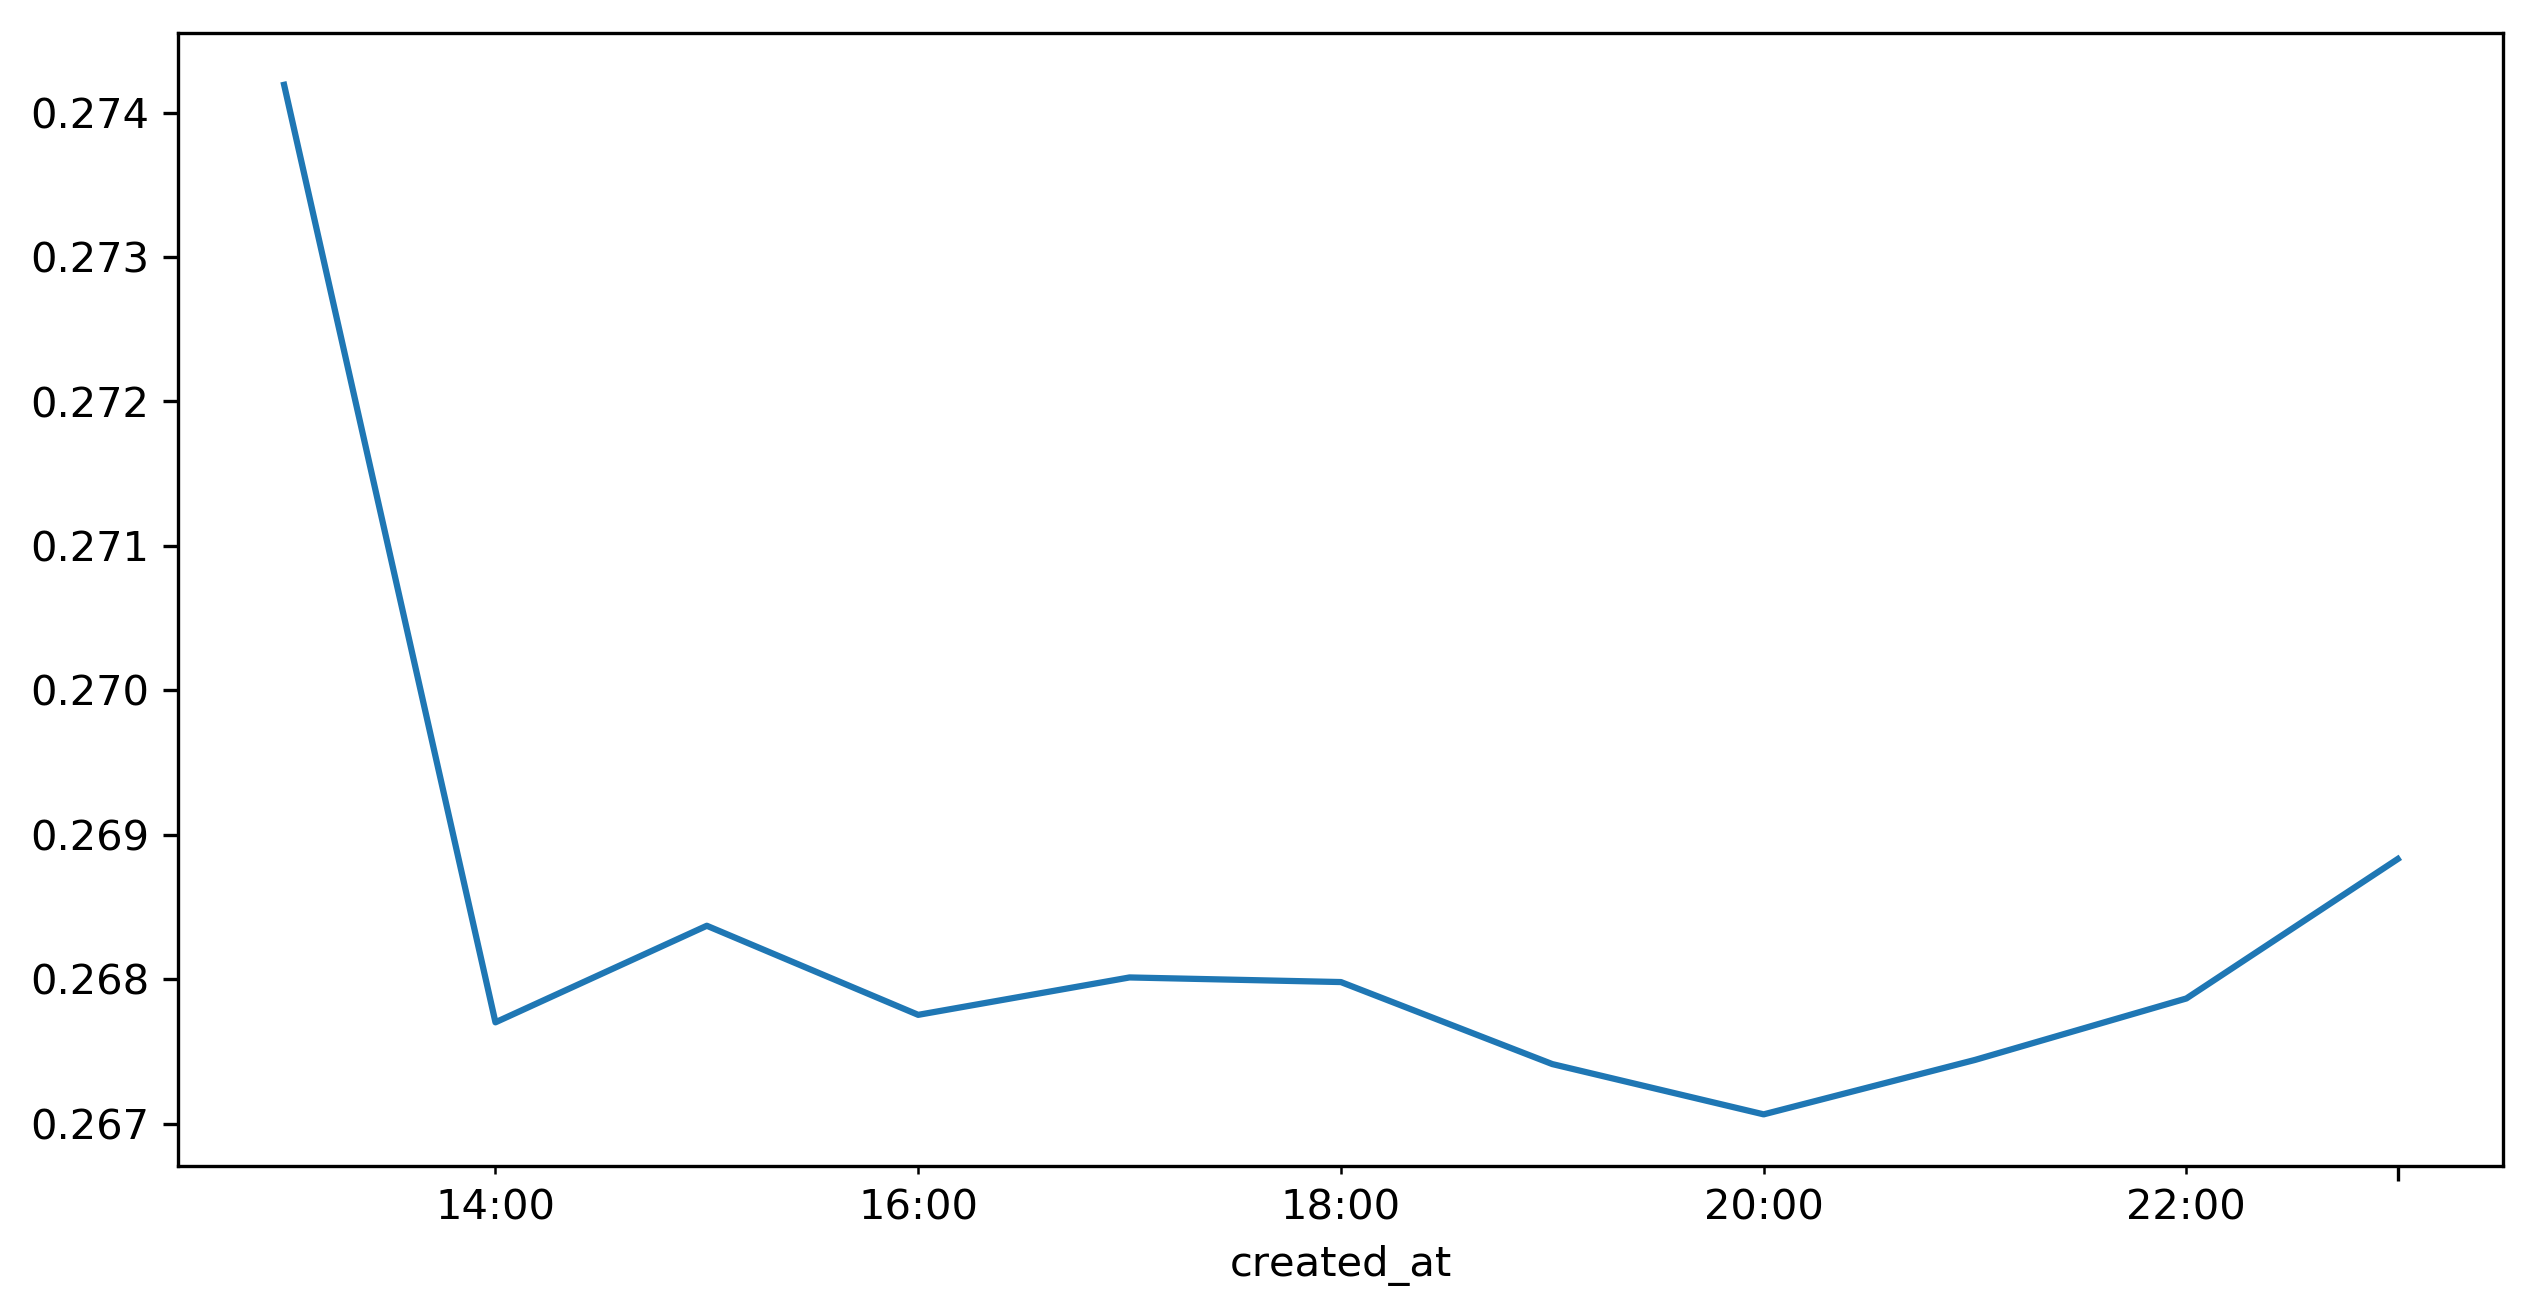

In [57]:
iolatency['28-9-2018'].resample('H').mean().plot()

In [58]:
rng = pd.date_range('28-9-2018', periods=13, freq='D')
rng

DatetimeIndex(['2018-09-28', '2018-09-29', '2018-09-30', '2018-10-01',
               '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
               '2018-10-06', '2018-10-07', '2018-10-08', '2018-10-09',
               '2018-10-10'],
              dtype='datetime64[ns]', freq='D')

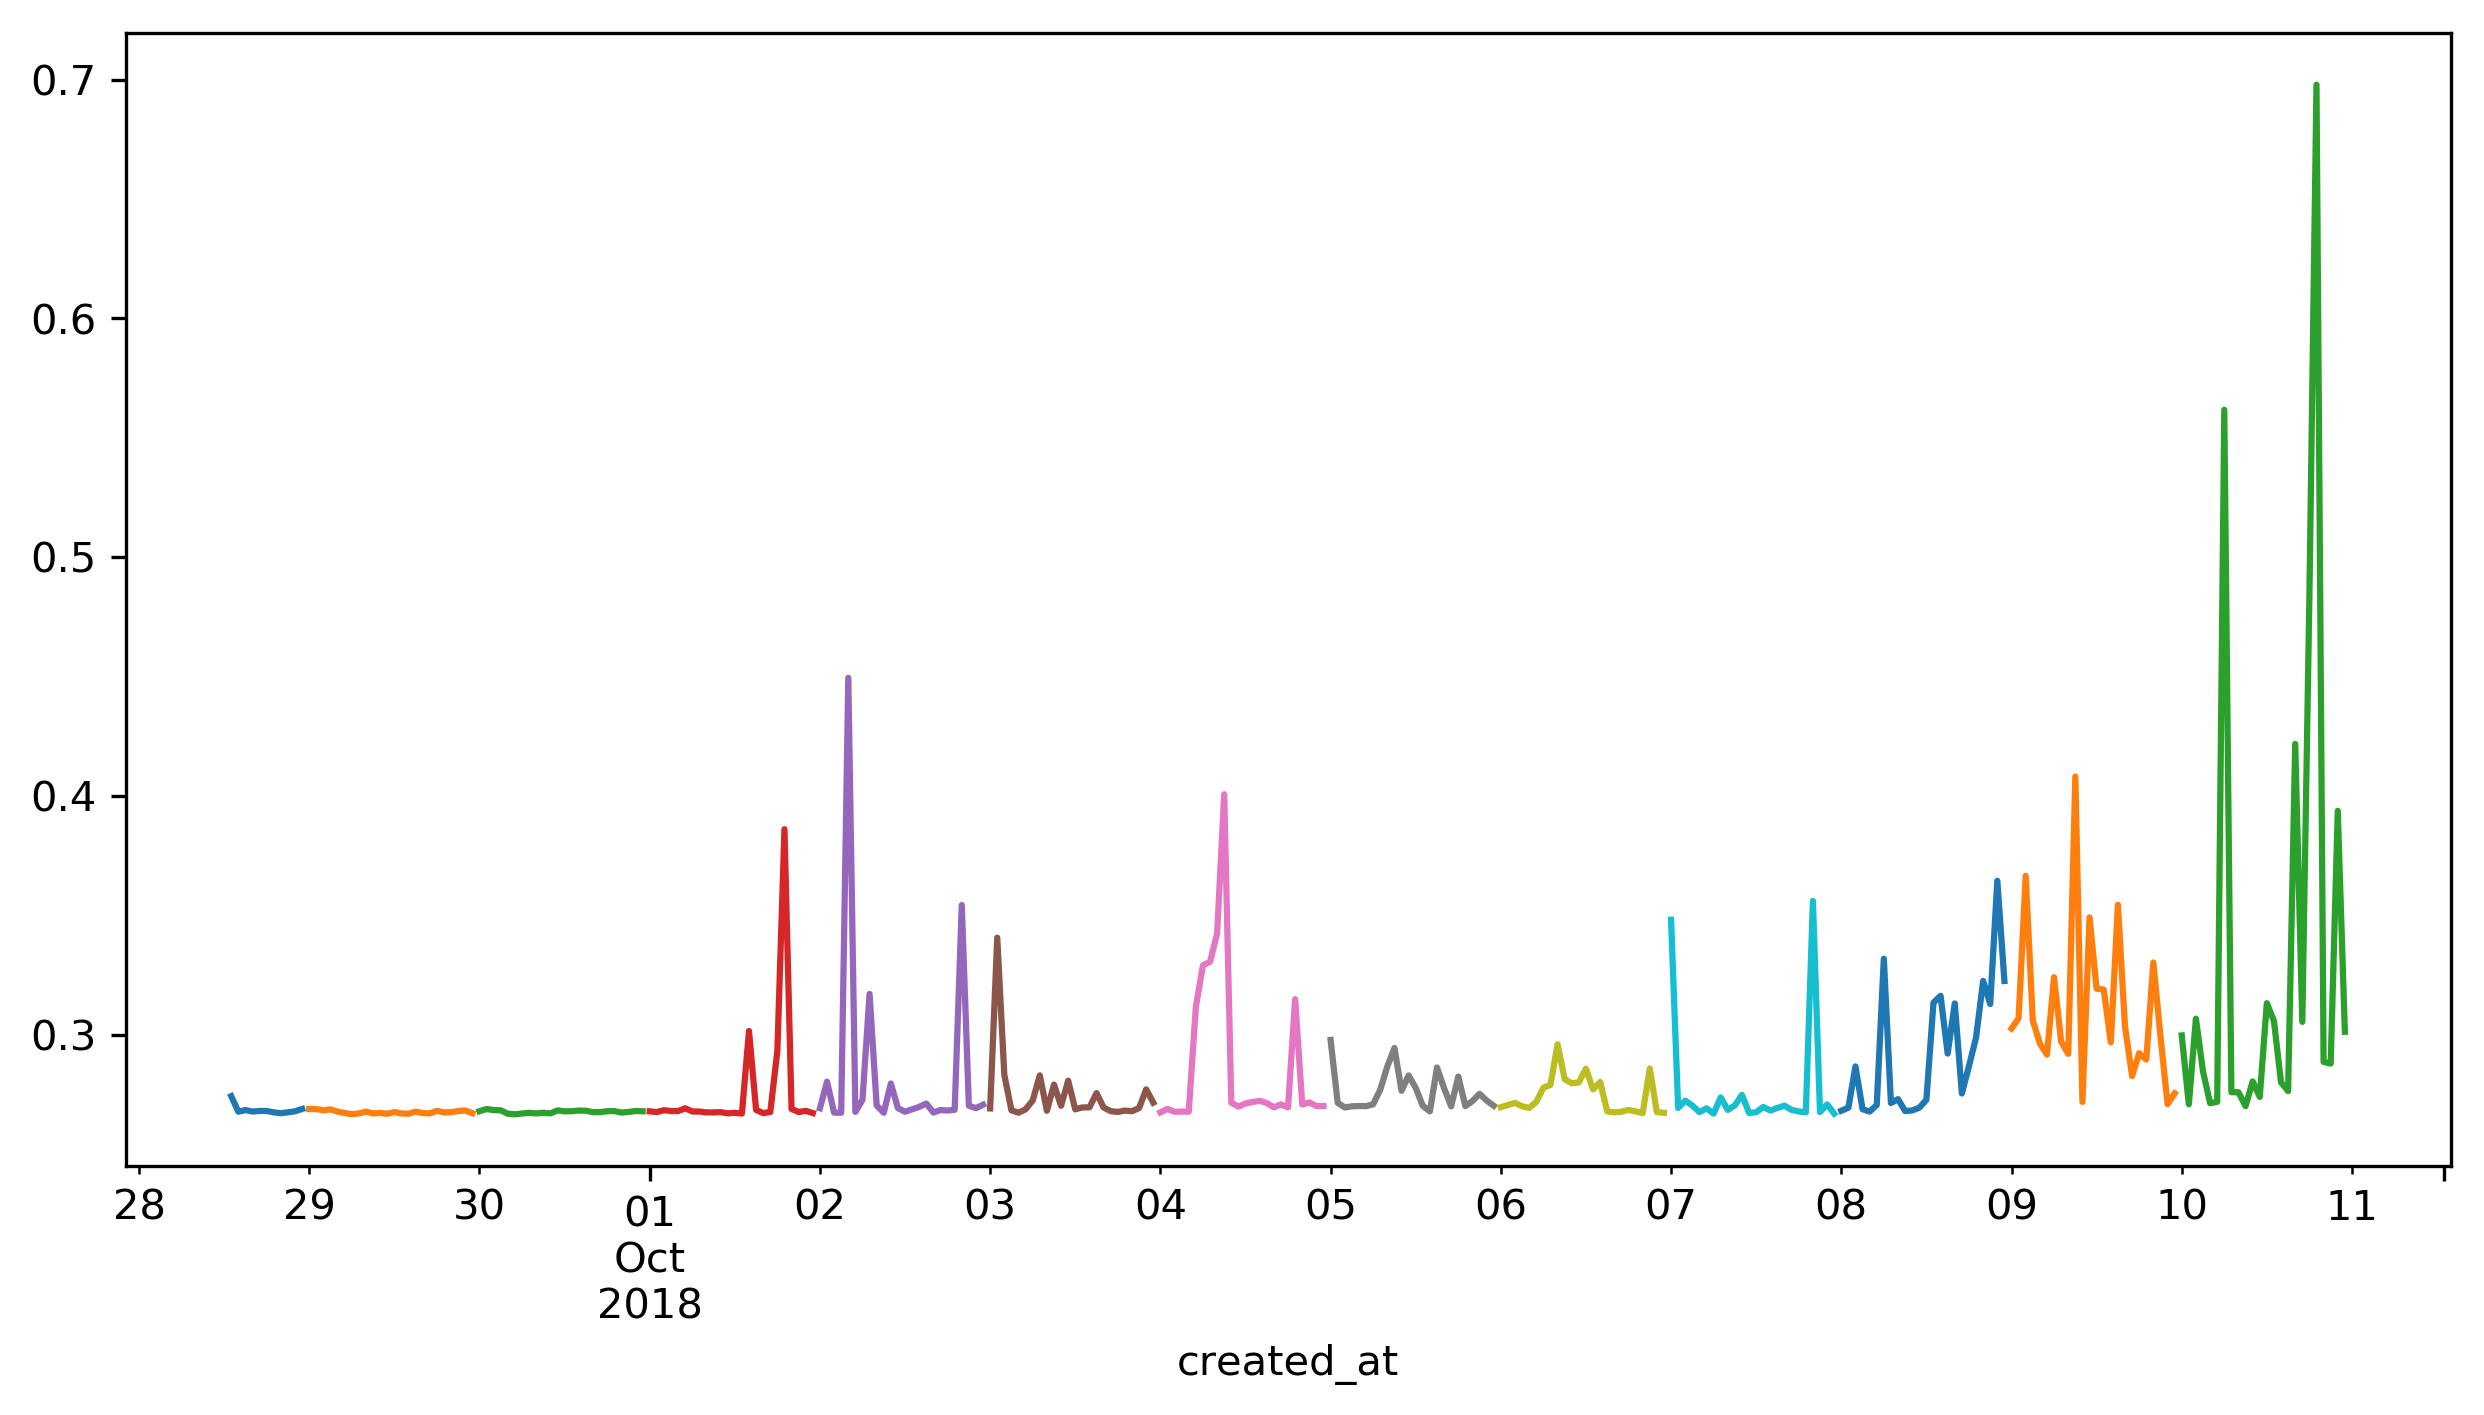

In [59]:
for i in rng:
    iolatency[str(i.year)+'-'+str(i.month)+'-'+str(i.day)].resample('H').mean().plot()

In [60]:
hrng = pd.date_range('28-9-2018', periods=23*24, freq='H')

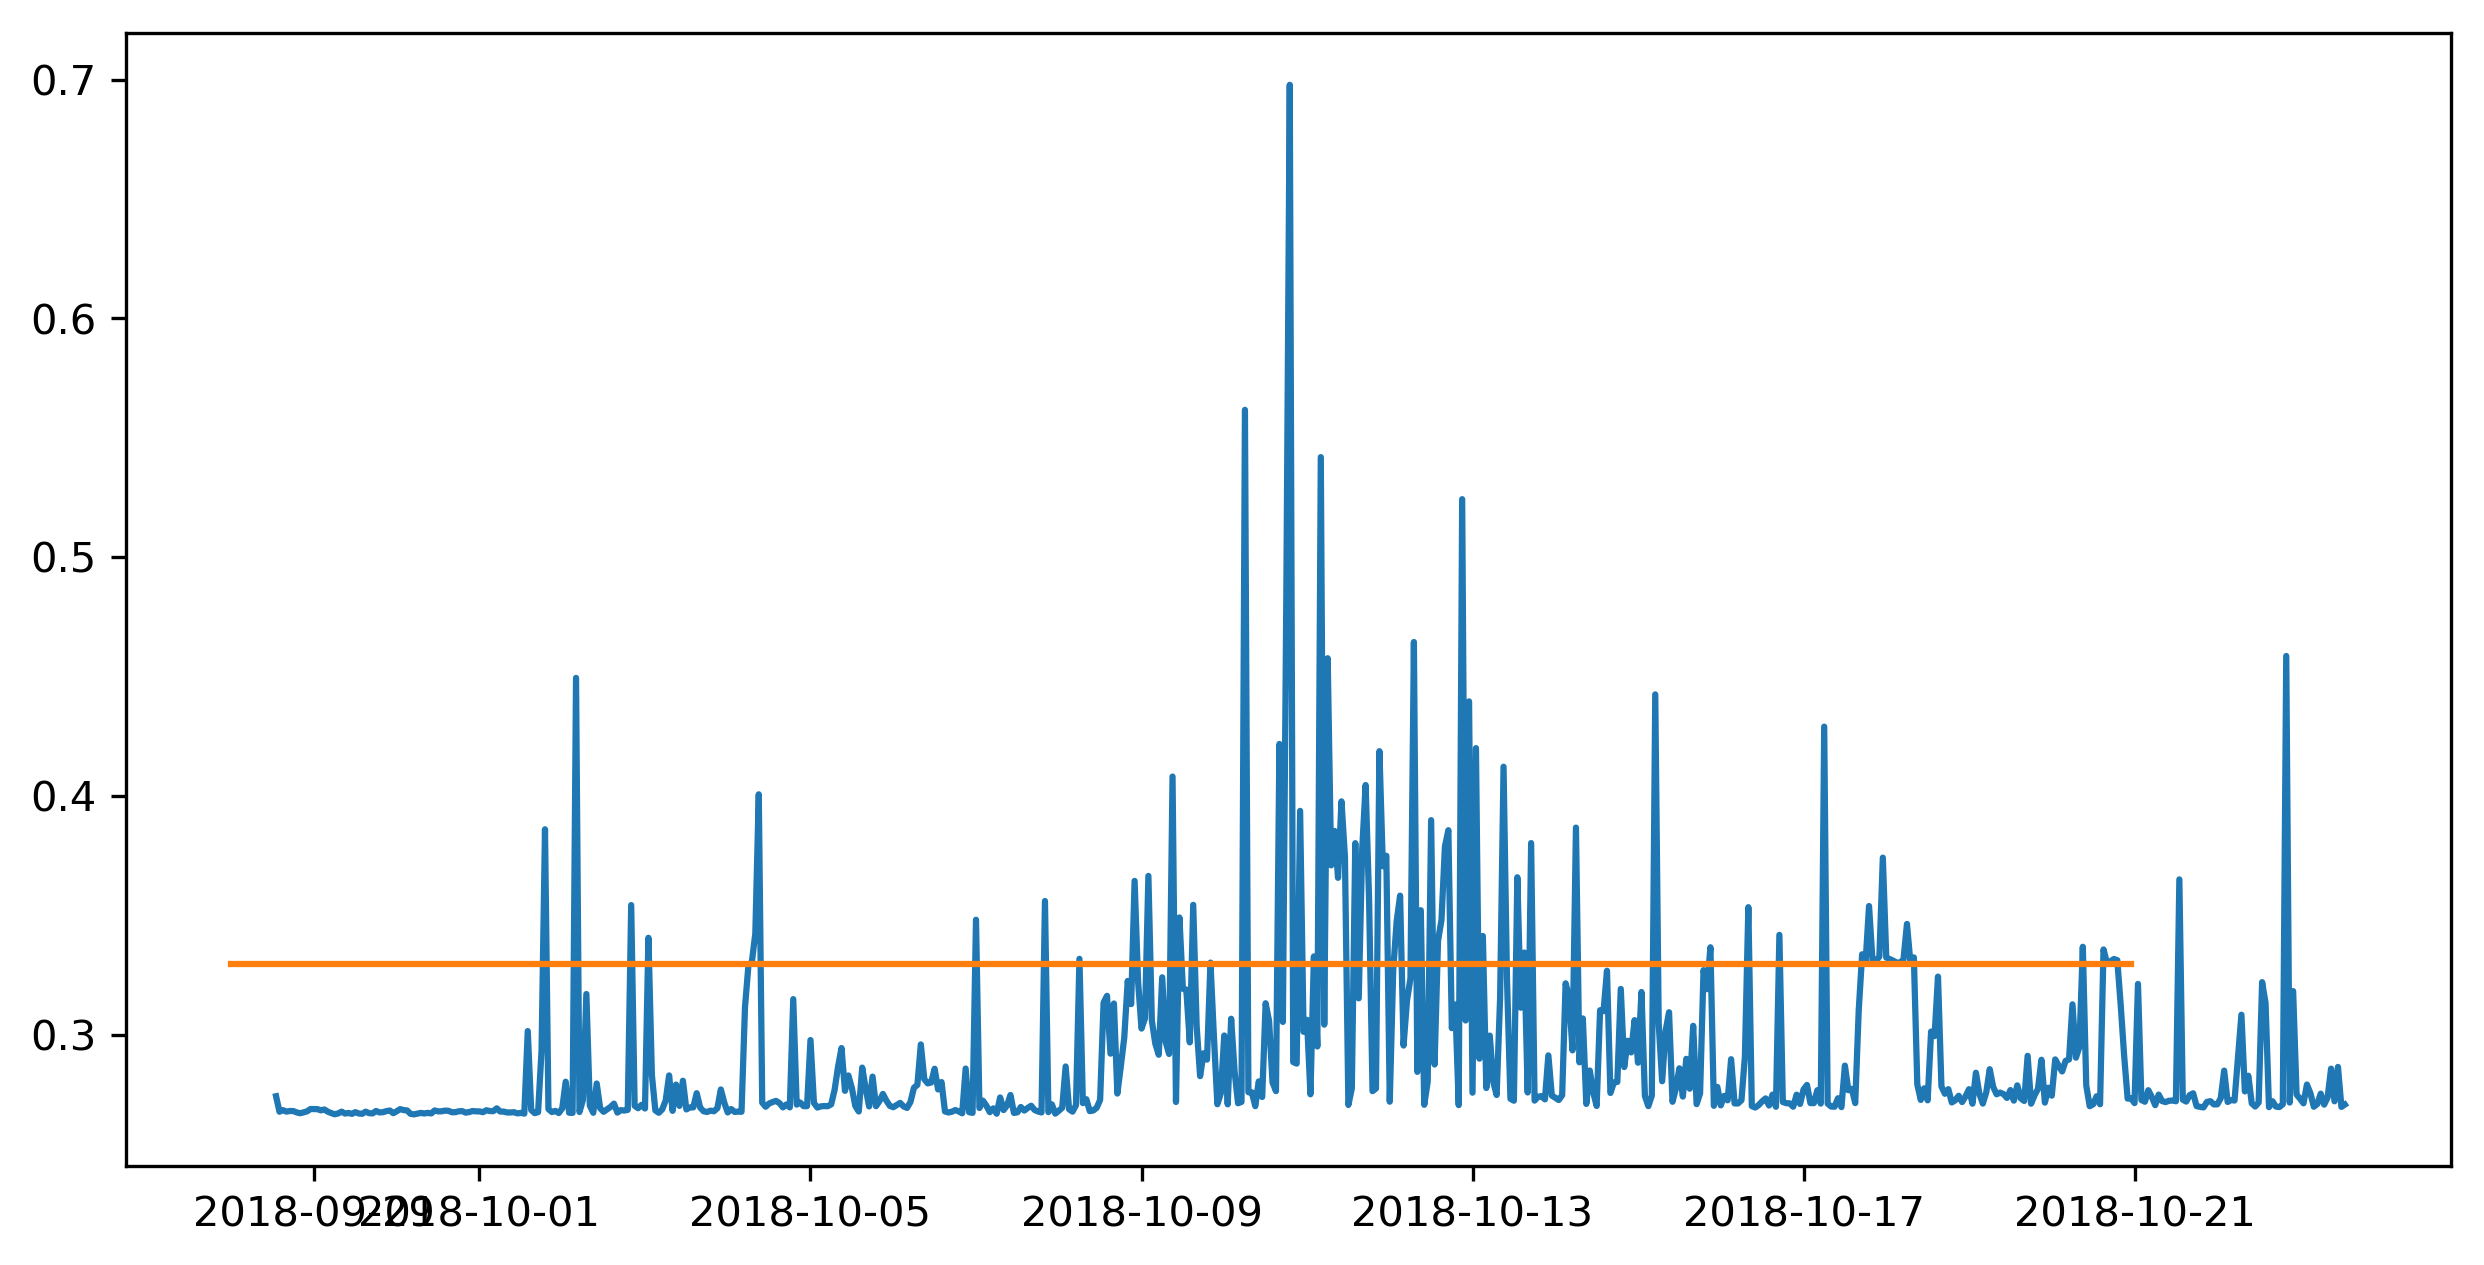

In [61]:
plt.plot(iolatency.resample('1H').mean())
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hrng))


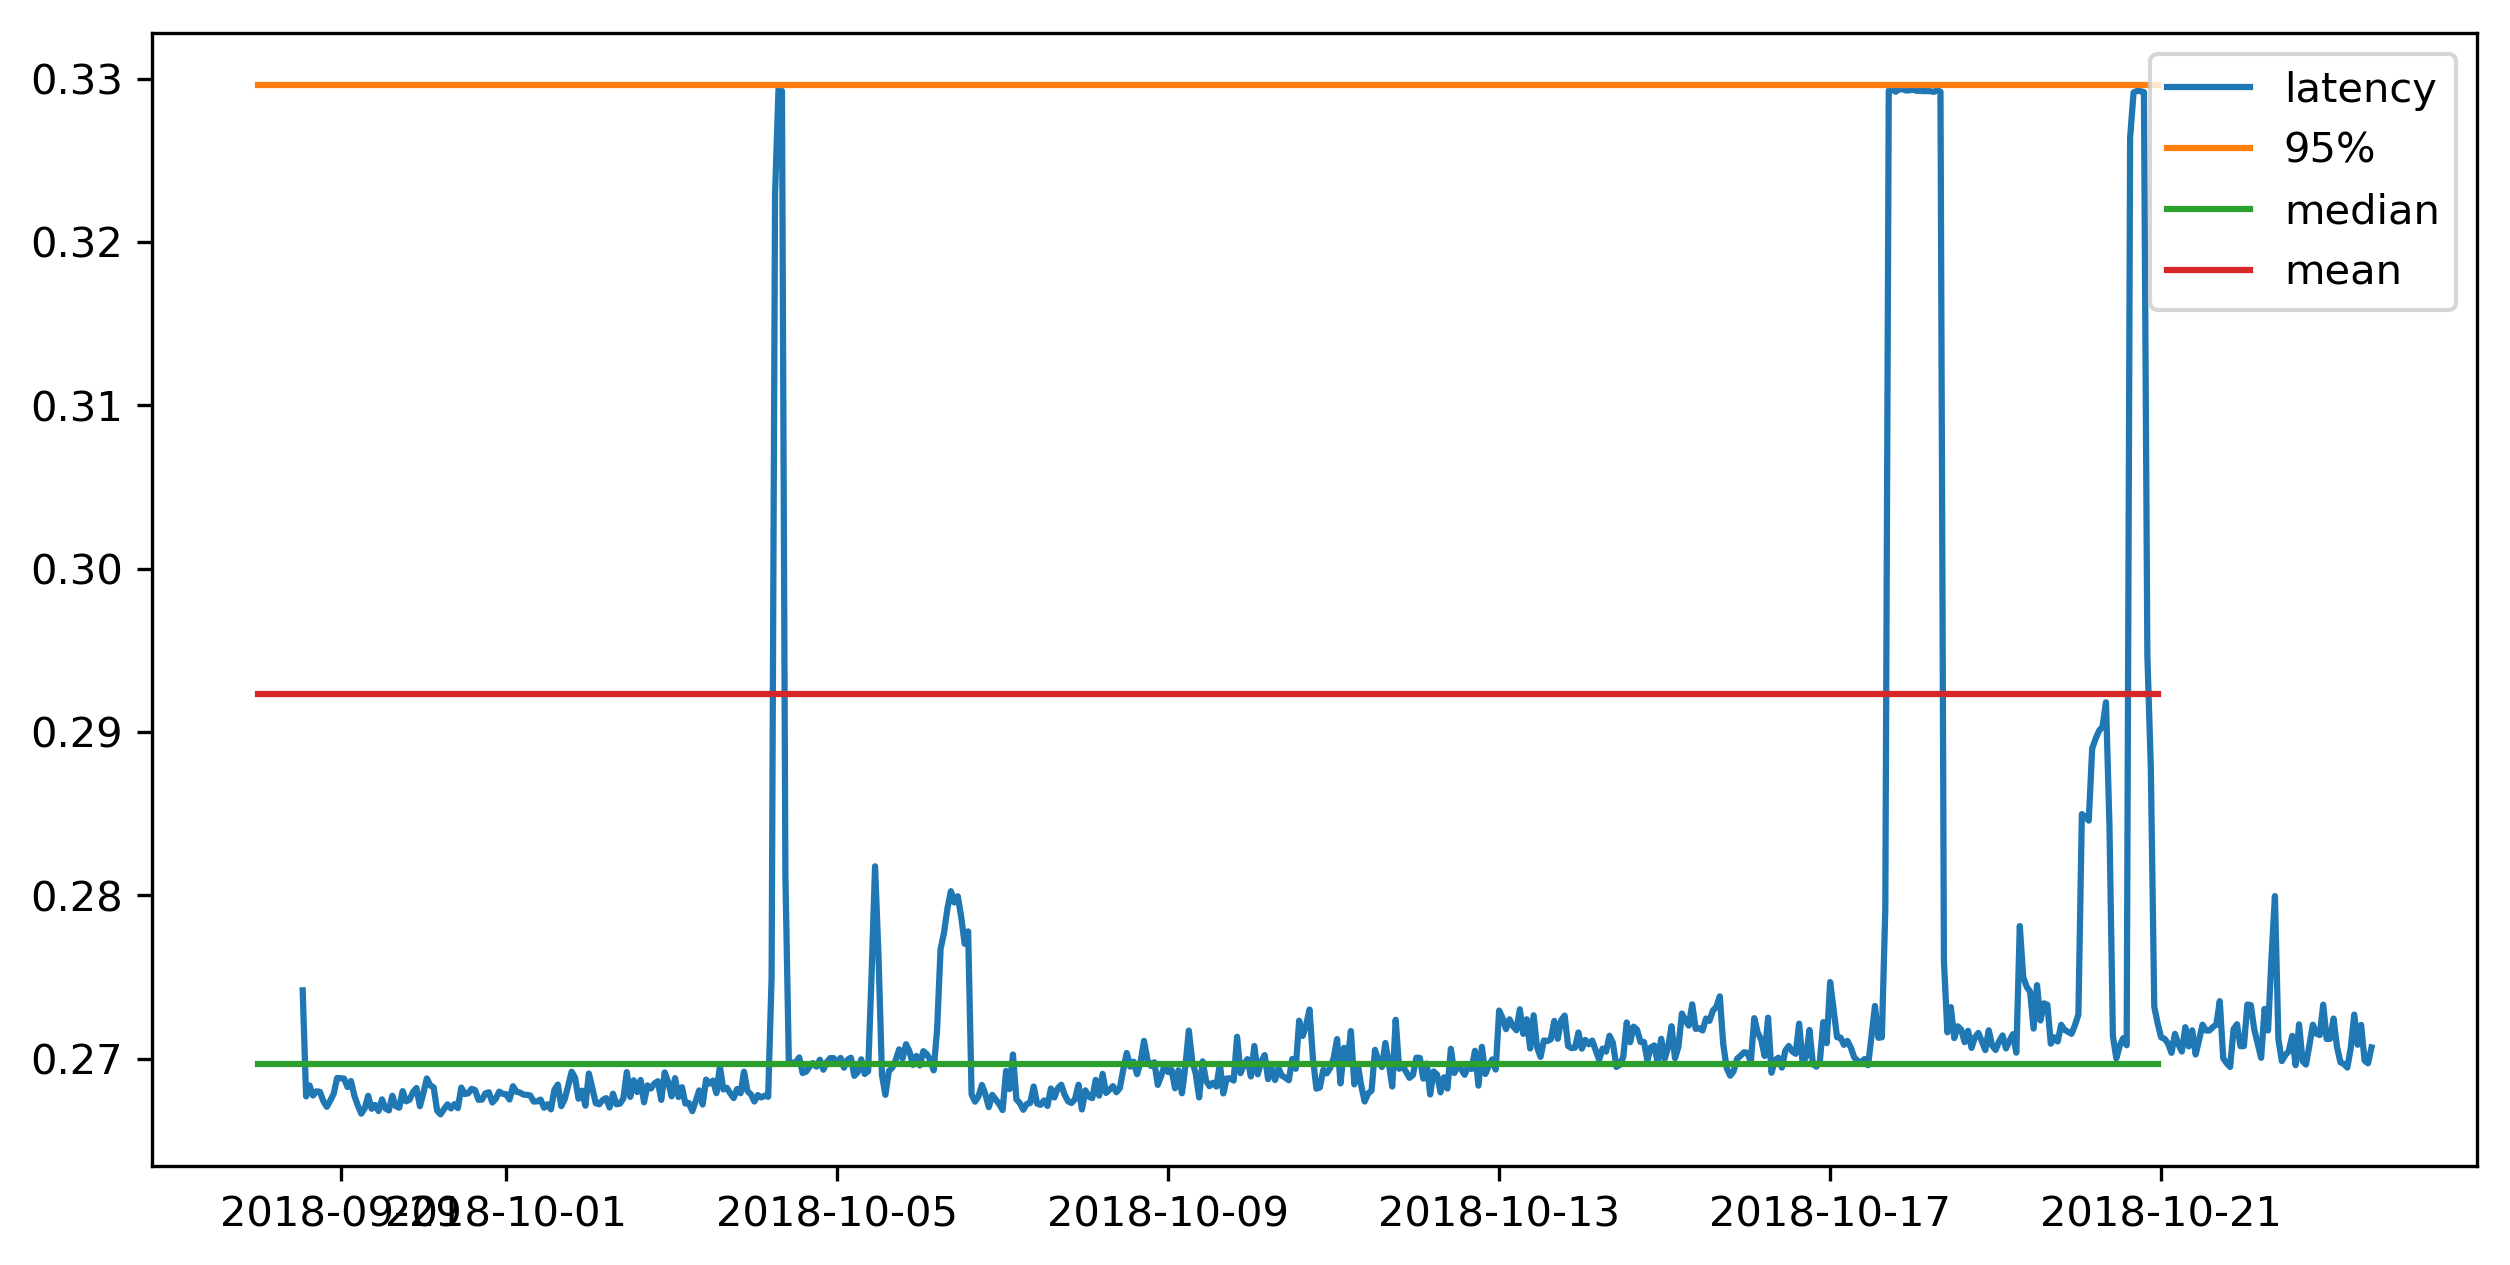

In [62]:
plt.plot(iolatency95.resample('1H').mean())
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hrng), label='95%')
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','50%')]]*len(hrng), label='median')
plt.plot(hrng, [statistics_df.loc[('ireland','oregon'),('latency','mean')]]*len(hrng), label='mean')
plt.legend()

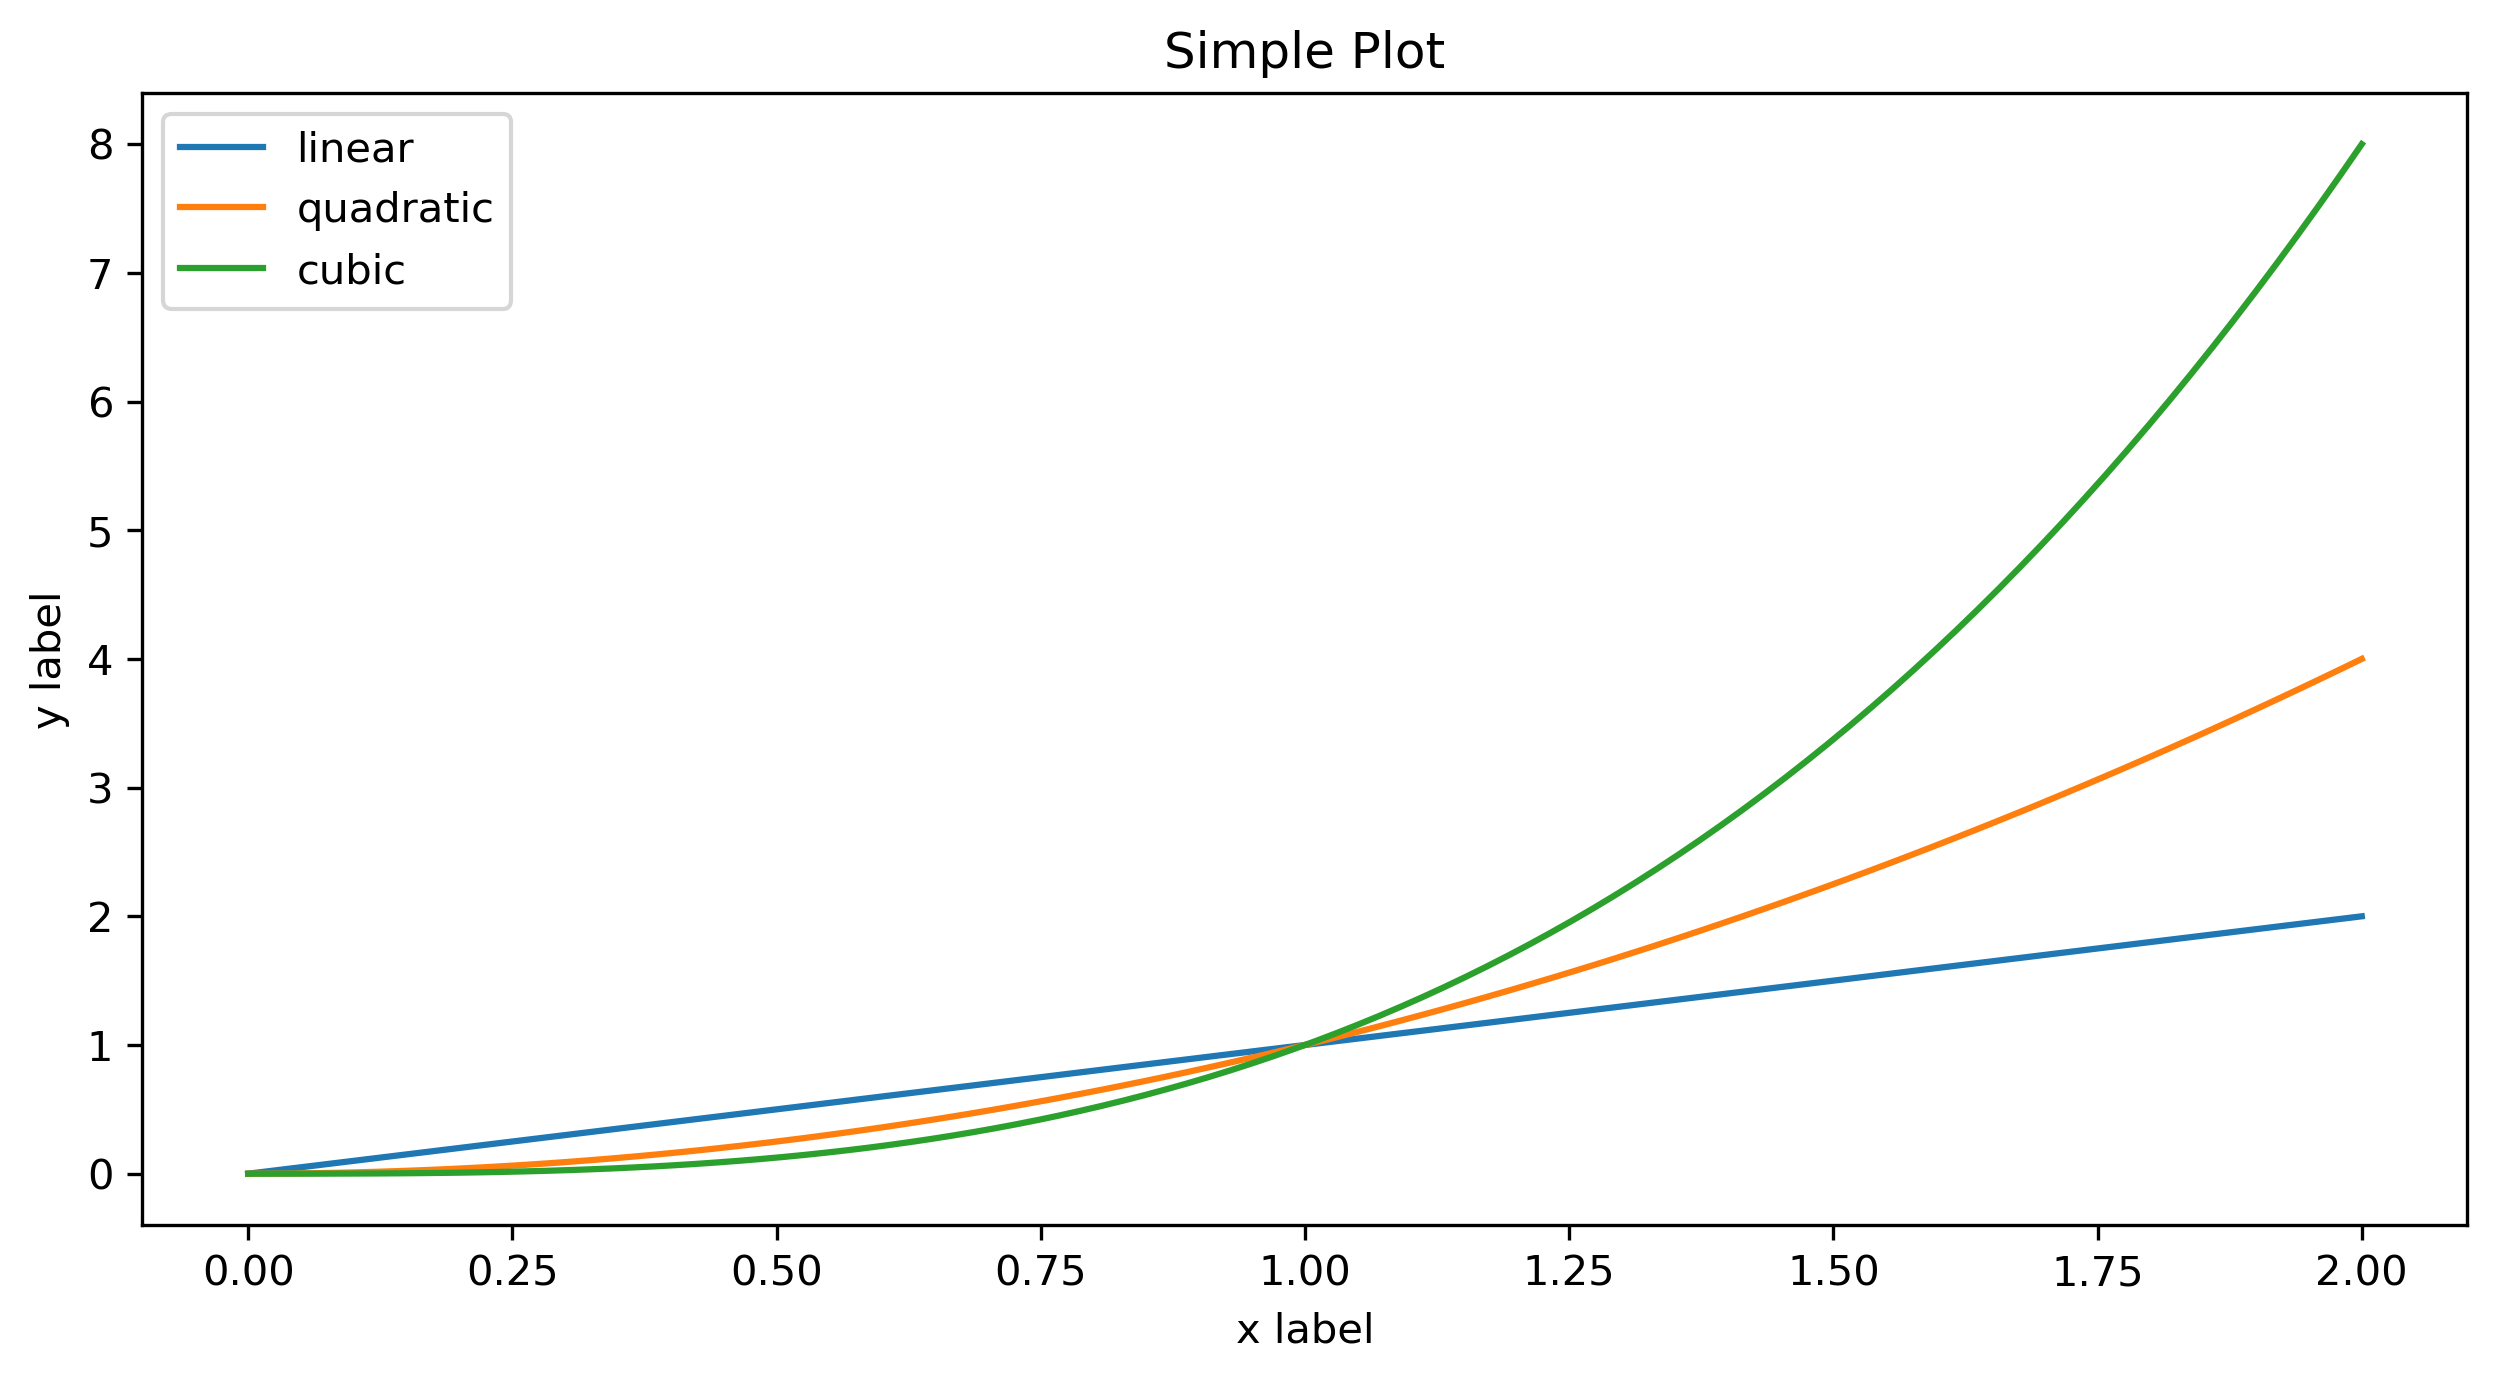

In [63]:
x = np.linspace(0, 2, 100)

plt.plot(x, x, label='linear')
plt.plot(x, x**2, label='quadratic')
plt.plot(x, x**3, label='cubic')

plt.xlabel('x label')
plt.ylabel('y label')

plt.title("Simple Plot")

plt.legend()

plt.show()

In [64]:
df_ts.index

DatetimeIndex(['2018-09-28 13:57:59', '2018-09-28 13:58:00',
               '2018-09-28 13:58:00', '2018-09-28 13:58:03',
               '2018-09-28 13:58:04', '2018-09-28 13:58:04',
               '2018-09-28 13:58:12', '2018-09-28 13:58:12',
               '2018-09-28 13:58:13', '2018-09-28 13:58:14',
               ...
               '2018-10-23 13:44:14', '2018-10-23 13:44:34',
               '2018-10-23 13:44:34', '2018-10-23 13:44:34',
               '2018-10-23 13:44:34', '2018-10-23 13:44:34',
               '2018-10-23 13:44:34', '2018-10-23 13:44:34',
               '2018-10-23 13:44:34', '2018-10-23 13:44:35'],
              dtype='datetime64[ns]', name='created_at', length=431328, freq=None)

===============================================================
===============================================================

## Distances

In [65]:
#distance in km
distance = {
"ireland_sydney":17209,
"ireland_oregon": 7486,
"ireland_saopaulo": 9354,
"oregon_sydney": 12342,
"oregon_saopaulo": 10825,
"sydney_saopaulo": 13386
}

sorted(distance.items(), key= lambda x: x[1])

[('ireland_oregon', 7486),
 ('ireland_saopaulo', 9354),
 ('oregon_saopaulo', 10825),
 ('oregon_sydney', 12342),
 ('sydney_saopaulo', 13386),
 ('ireland_sydney', 17209)]

In [66]:
speed_of_light = constants.c/1000 #km/s
speed_of_light

299792.458

In [67]:
theoretical_time = {
"ireland_sydney": distance["ireland_sydney"]*2/speed_of_light,
"ireland_oregon": distance["ireland_oregon"]*2/speed_of_light,
"ireland_saopaulo": distance["ireland_saopaulo"]*2/speed_of_light,
"oregon_sydney": distance["oregon_sydney"]*2/speed_of_light,
"oregon_saopaulo": distance["oregon_saopaulo"]*2/speed_of_light,
"sydney_saopaulo": distance["sydney_saopaulo"]*2/speed_of_light 
}
theoretical_time

{'ireland_oregon': 0.04994121633306733,
 'ireland_saopaulo': 0.062403170929670286,
 'ireland_sydney': 0.11480609028529998,
 'oregon_saopaulo': 0.07221662661039992,
 'oregon_sydney': 0.08233696125871186,
 'sydney_saopaulo': 0.08930177956644927}

In [68]:
latency95 = df95Grouped.mean()
latency95['theoretical_time'] = [theoretical_time["ireland_oregon"], theoretical_time["ireland_saopaulo"], theoretical_time["ireland_sydney"],
theoretical_time["ireland_oregon"],theoretical_time["oregon_saopaulo"],theoretical_time["oregon_sydney"],
theoretical_time["ireland_saopaulo"],theoretical_time["oregon_saopaulo"],theoretical_time["sydney_saopaulo"],
theoretical_time["ireland_sydney"],theoretical_time["oregon_sydney"],theoretical_time["sydney_saopaulo"]]
latency95['real/theoretical'] = latency95['latency']/latency95['theoretical_time']
latency95.sort_values('real/theoretical')

,,latency,theoretical_time,real/theoretical
origin,destination,,,
oregon,sydney,0.309329,0.082337,3.756870
sydney,oregon,0.309452,0.082337,3.758362
ireland,sydney,0.550614,0.114806,4.796039
sydney,ireland,0.550703,0.114806,4.796807
oregon,ireland,0.269971,0.049941,5.405782
ireland,oregon,0.271157,0.049941,5.429526
oregon,saopaulo,0.403891,0.072217,5.592775
saopaulo,oregon,0.405521,0.072217,5.615341
ireland,saopaulo,0.397031,0.062403,6.362346


## Machine learning classifier

In [71]:
df95.head()

,origin,destination,latency,created_at
id,,,,
15,ireland,oregon,0.274516,2018-09-28 13:57:59
16,ireland,saopaulo,0.397710,2018-09-28 13:58:00
21,sydney,saopaulo,0.670447,2018-09-28 13:58:04
23,saopaulo,oregon,0.395145,2018-09-28 13:58:12
24,saopaulo,ireland,0.416015,2018-09-28 13:58:12


In [158]:
latency_dataset = {'target_names': ['ireland_oregon', 'ireland_saopaulo', 'ireland_sydney', 'oregon_saopaulo', 'oregon_sydney', 'saopaulo_sydney'], 'feature_names': ['latency']}

In [146]:
df95Grouped.get_group(('ireland','oregon'))['latency'].size

34146

In [159]:
ireland_oregon_data = np.reshape(df95Grouped.get_group(('ireland','oregon'))['latency'].values,(34146,1))
ireland_saopaulo_data = np.reshape(df95Grouped.get_group(('ireland','saopaulo'))['latency'].values,(34146,1))
ireland_sydney_data = np.reshape(df95Grouped.get_group(('ireland','sydney'))['latency'].values,(34146,1))
oregon_saopaulo_data = np.reshape(df95Grouped.get_group(('oregon','saopaulo'))['latency'].values,(34146,1))
oregon_sydney_data = np.reshape(df95Grouped.get_group(('oregon','sydney'))['latency'].values,(34146,1))
saopaulo_sydney_data = np.reshape(df95Grouped.get_group(('saopaulo','sydney'))['latency'].values,(34146,1))
data = np.concatenate((ireland_oregon_data,ireland_saopaulo_data,ireland_sydney_data,oregon_saopaulo_data,oregon_sydney_data,saopaulo_sydney_data))
data

array([[0.27451589],
       [0.28220566],
       [0.26585652],
       ...,
       [0.64004141],
       [0.63929525],
       [0.63976074]])

In [160]:
target = np.concatenate((np.full(34146, 0),np.full(34146, 1),np.full(34146, 2),np.full(34146, 3),np.full(34146, 4),np.full(34146, 5)))
target

array([0, 0, 0, ..., 5, 5, 5])

In [161]:
##sanity check
print(data.size == target.size)
print(data.shape)
print(target.shape)

True
(204876, 1)
(204876,)


In [162]:
latency_dataset['data'] = data
latency_dataset['target'] = target

In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    latency_dataset['data'], latency_dataset['target'], random_state=0)

In [164]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (153657, 1)
y_train shape: (153657,)
X_test shape: (51219, 1)
y_test shape: (51219,)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126cd3c18>]],
      dtype=object)

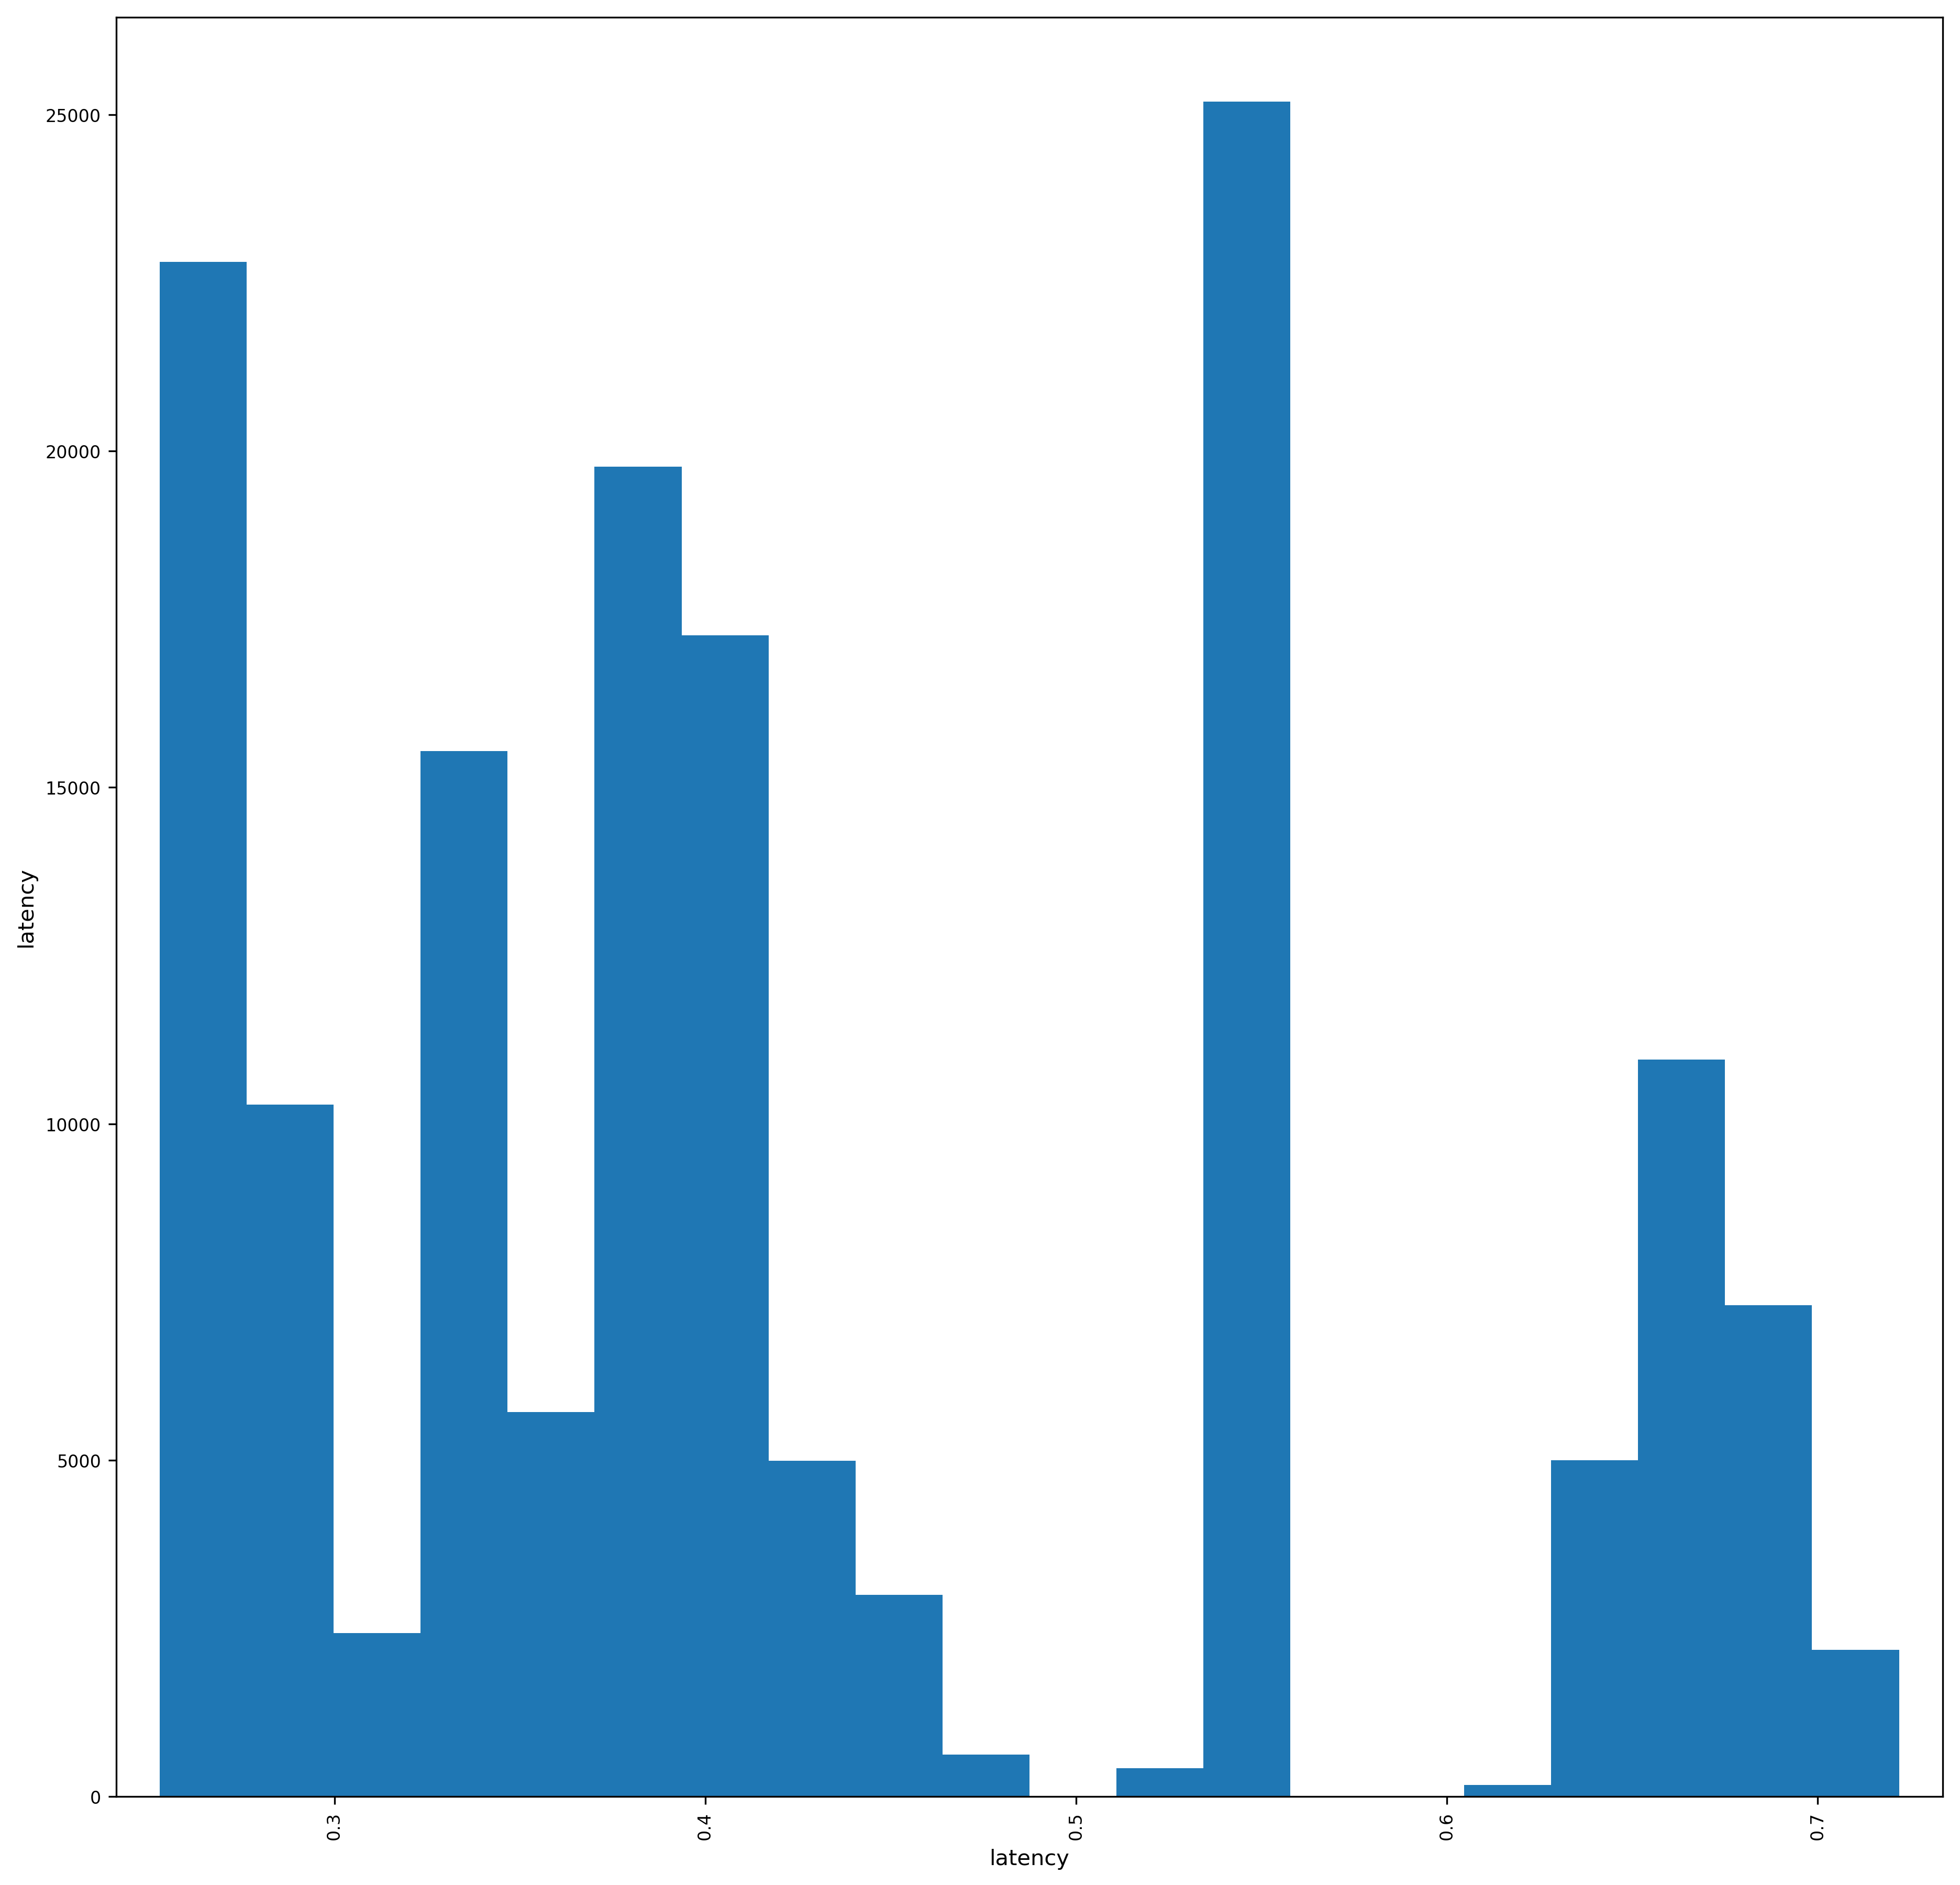

In [165]:
# create dataframe from data in X_train
train_dataframe = pd.DataFrame(X_train, columns=latency_dataset['feature_names'])
# create a scatter matrix from the dataframe, color by y_train
pd.plotting.scatter_matrix(train_dataframe, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

In [205]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)

In [206]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [207]:
y_pred = knn.predict(X_test)
print("Test set predictions:\n", y_pred)

Test set predictions:
 [3 1 1 ... 4 3 1]


In [208]:
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 0.94


In [209]:
X_new = np.array([[0.40]])
prediction = knn.predict(X_new)[0]
print("Prediction:", prediction)
print("Predicted target name:",latency_dataset['target_names'][prediction])

Prediction: 3
Predicted target name: oregon_saopaulo
